<a href="https://colab.research.google.com/github/DanAkarca/modular_experts/blob/main/testing_varied_architectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Experiement: Testing homogeneous, modular and heterogeneous modular mixture of network experiments

In [23]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple, Dict
import seaborn as sns
from tqdm import tqdm
import pandas as pd

def generate_complex_patterns(num_samples: int, grid_size: int = 8) -> Tuple[torch.Tensor, torch.Tensor]:
    """Generate complex pattern completion data with biased sampling towards extreme densities"""
    inputs = []
    targets = []

    # Define patterns and their target probabilities
    pattern_configs = {
        'sparse_stripes': {'spacing': 4, 'width': 1, 'prob': 0.2},      # Very sparse
        'dense_stripes': {'spacing': 3, 'width': 2, 'prob': 0.2},       # Very dense
        'sparse_blocks': {'density': 0.2, 'prob': 0.15},                # Very sparse
        'dense_blocks': {'density': 0.8, 'prob': 0.15},                 # Very dense
        'thin_spiral': {'thickness': 0.5, 'prob': 0.1},                 # Very sparse
        'thick_spiral': {'thickness': 2.5, 'prob': 0.1},                # Very dense
        'sparse_random': {'density': 0.1, 'prob': 0.05},                # Extremely sparse
        'dense_random': {'density': 0.9, 'prob': 0.05}                  # Extremely dense
    }

    def create_stripes(size, spacing, width):
        pattern = torch.zeros((size, size))
        for i in range(size):
            for j in range(size):
                if (i + j) % spacing < width:
                    pattern[i, j] = 1
        return pattern

    def create_blocks(size, density):
        pattern = torch.zeros((size, size))
        block_size = 2
        num_blocks = size // block_size
        for i in range(0, size, block_size):
            for j in range(0, size, block_size):
                if torch.rand(1).item() < density:
                    pattern[i:i+block_size, j:j+block_size] = 1
        return pattern

    def create_spiral(size, thickness):
        pattern = torch.zeros((size, size))
        center = size // 2
        for i in range(size):
            for j in range(size):
                x, y = i - center, j - center
                r = np.sqrt(x*x + y*y)
                angle = np.arctan2(y, x)
                if angle < 0:
                    angle += 2 * np.pi
                a = 2
                theta = r / a
                spiral_r = a * (angle / (2 * np.pi))
                if abs(r - spiral_r) < thickness:
                    pattern[i, j] = 1
        return pattern

    def create_random_pattern(size, density):
        return (torch.rand((size, size)) < density).float()

    probabilities = [config['prob'] for config in pattern_configs.values()]
    pattern_types = list(pattern_configs.keys())

    for _ in range(num_samples):
        # Sample pattern type according to specified probabilities
        pattern_type = np.random.choice(pattern_types, p=probabilities)
        config = pattern_configs[pattern_type]

        # Generate pattern based on type
        if 'stripes' in pattern_type:
            pattern = create_stripes(grid_size, config['spacing'], config['width'])
        elif 'blocks' in pattern_type:
            pattern = create_blocks(grid_size, config['density'])
        elif 'spiral' in pattern_type:
            pattern = create_spiral(grid_size, config['thickness'])
        else:  # random
            pattern = create_random_pattern(grid_size, config['density'])

        # Create masked input with biased masking
        masked = pattern.clone()

        if np.random.random() < 0.3:
            # Block masking with varying sizes
            block_size = np.random.randint(2, 4)
            num_blocks = np.random.randint(1, 3)

            for _ in range(num_blocks):
                start_i = np.random.randint(0, grid_size - block_size)
                start_j = np.random.randint(0, grid_size - block_size)
                masked[start_i:start_i+block_size, start_j:start_j+block_size] = 0
        else:
            # Biased random masking
            density = pattern.mean().item()
            if density > 0.5:
                # For dense patterns, mask more 1s
                mask = torch.rand(grid_size, grid_size) > (0.7 * pattern + 0.1)
            else:
                # For sparse patterns, mask more 0s
                mask = torch.rand(grid_size, grid_size) > (0.7 * (1 - pattern) + 0.1)

            masked[mask] = 0

        inputs.append(masked.flatten())
        targets.append(pattern.flatten())

    return torch.stack(inputs), torch.stack(targets)

def analyze_pattern_statistics(num_samples=1000, grid_size=8):
    """Analyze the statistics of generated patterns"""
    inputs, targets = generate_complex_patterns(num_samples, grid_size)

    # Overall statistics
    mean_density = targets.mean().item()
    std_density = targets.std().item()

    print(f"Pattern Statistics:")
    print(f"Mean density: {mean_density:.3f}")
    print(f"Std density: {std_density:.3f}")
    print(f"Random baseline accuracy: {max(mean_density, 1-mean_density)*100:.1f}%")

    # Visualize some examples
    fig, axs = plt.subplots(4, 4, figsize=(12, 12))
    fig.suptitle("Sample Patterns")

    for i in range(4):
        for j in range(4):
            idx = i * 4 + j
            if idx < len(targets):
                axs[i, j].imshow(targets[idx].reshape(grid_size, grid_size), cmap='Blues')
                density = targets[idx].mean().item()
                axs[i, j].set_title(f'Density: {density:.2f}')
                axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

class BaseExpert(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )
        self.param_count = sum(p.numel() for p in self.parameters())

    def forward(self, x):
        return torch.sigmoid(self.net(x))

class HomogeneousNetwork(nn.Module):
    def __init__(self, input_size: int, total_params: int):
        super().__init__()
        self.hidden_size = total_params // (3 * input_size)
        self.expert = BaseExpert(input_size, self.hidden_size, input_size)

    def forward(self, x):
        return self.expert(x)

class ModularHomogeneous(nn.Module):
    def __init__(self, input_size: int, total_params: int, num_experts: int):
        super().__init__()
        self.hidden_size = total_params // (3 * input_size * num_experts)
        self.num_experts = num_experts
        self.input_size = input_size

        self.experts = nn.ModuleList([
            BaseExpert(input_size, self.hidden_size, input_size)
            for _ in range(num_experts)
        ])
        self.router = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_experts)
        )

    def forward(self, x):
        batch_size = x.shape[0] if len(x.shape) > 1 else 1
        if len(x.shape) == 1:
            x = x.unsqueeze(0)

        routing_weights = torch.softmax(self.router(x), dim=-1)
        expert_outputs = torch.stack([expert(x) for expert in self.experts])
        expert_outputs = expert_outputs.permute(1, 0, 2)
        routing_weights = routing_weights.unsqueeze(-1)

        output = torch.sum(routing_weights * expert_outputs, dim=1)
        return output.squeeze(0) if batch_size == 1 else output

class ModularHeterogeneous(nn.Module):
    def __init__(self, input_size: int, total_params: int, expert_ratios: List[float]):
        super().__init__()
        self.input_size = input_size
        self.num_experts = len(expert_ratios)

        total_ratio = sum(expert_ratios)
        expert_sizes = [int((ratio/total_ratio) * total_params // (3 * input_size))
                       for ratio in expert_ratios]

        self.experts = nn.ModuleList([
            BaseExpert(input_size, size, input_size)
            for size in expert_sizes
        ])

        self.router = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, self.num_experts)
        )

    def forward(self, x):
        batch_size = x.shape[0] if len(x.shape) > 1 else 1
        if len(x.shape) == 1:
            x = x.unsqueeze(0)

        routing_weights = torch.softmax(self.router(x), dim=-1)
        expert_outputs = torch.stack([expert(x) for expert in self.experts])
        expert_outputs = expert_outputs.permute(1, 0, 2)
        routing_weights = routing_weights.unsqueeze(-1)

        output = torch.sum(routing_weights * expert_outputs, dim=1)
        return output.squeeze(0) if batch_size == 1 else output

def calculate_pattern_accuracy(outputs: torch.Tensor, targets: torch.Tensor, threshold: float = 0.5) -> float:
    """Calculate pattern-wise accuracy - a pattern is correct only if all pixels match"""
    predictions = (outputs > threshold).float()
    targets = (targets > threshold).float()
    correct_patterns = torch.all(predictions == targets, dim=1)
    return correct_patterns.float().mean().item() * 100

def calculate_random_baseline(targets: torch.Tensor) -> float:
    """Calculate random baseline for pattern-wise accuracy"""
    p_ones = targets.mean().item()
    p_zeros = 1 - p_ones
    p_correct_pixel = max(p_ones, p_zeros)
    num_pixels = targets.shape[1]  # Number of pixels in each pattern
    return (p_correct_pixel ** num_pixels) * 100  # Probability of getting all pixels correct

def train_and_evaluate(model, train_data, train_targets, val_data, val_targets, epochs=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_loss = float('inf')
    best_state_dict = None

    for epoch in tqdm(range(epochs)):
        # Training
        model.train()
        optimizer.zero_grad()

        outputs = torch.sigmoid(model(train_data))
        loss = criterion(outputs, train_targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = torch.sigmoid(model(val_data))
            val_loss = criterion(val_outputs, val_targets)

            # Calculate pattern-wise accuracies
            train_acc = calculate_pattern_accuracy(outputs, train_targets)
            val_acc = calculate_pattern_accuracy(val_outputs, val_targets)

            train_loss_history.append(loss.item())
            train_acc_history.append(train_acc)
            val_loss_history.append(val_loss.item())
            val_acc_history.append(val_acc)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_state_dict = model.state_dict().copy()

            scheduler.step(val_loss)

        if epoch % 10 == 0:
            print(f'\nEpoch {epoch}/{epochs}:')
            print(f'Train Loss: {loss.item():.4f}, Train Pattern Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss.item():.4f}, Val Pattern Acc: {val_acc:.2f}%')

    model.load_state_dict(best_state_dict)
    return {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history
    }

def analyze_expert_usage(model: nn.Module, data: torch.Tensor, num_samples: int = 100) -> np.ndarray:
    """Analyze how different experts are used across different input patterns"""
    model.eval()
    with torch.no_grad():
        if hasattr(model, 'router'):
            indices = np.random.choice(len(data), num_samples, replace=False)
            samples = data[indices]
            routing_weights = torch.softmax(model.router(samples), dim=-1)
            return routing_weights.numpy()
    return None

def plot_enhanced_metrics(histories: Dict, epochs: int, random_baseline: float):
    """Plot enhanced training metrics with random baseline and confidence intervals"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Color palette
    colors = sns.color_palette("husl", len(histories))

    # Plot losses
    for (name, history), color in zip(histories.items(), colors):
        ax1.plot(history['train_loss'], label=f'{name} (Train)', color=color)
        ax1.plot(history['val_loss'], label=f'{name} (Val)',
                linestyle='--', color=color, alpha=0.7)

    ax1.set_title('Loss Over Time', fontsize=12, pad=10)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (BCE)')
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot accuracies with baseline
    for (name, history), color in zip(histories.items(), colors):
        ax2.plot(history['train_acc'], label=f'{name} (Train)', color=color)
        ax2.plot(history['val_acc'], label=f'{name} (Val)',
                linestyle='--', color=color, alpha=0.7)

    # Add random baseline
    ax2.axhline(y=random_baseline, color='red', linestyle=':',
                label='Random Baseline', alpha=0.7)

    ax2.set_title('Accuracy Over Time', fontsize=12, pad=10)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True, alpha=0.3)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot final performance comparison
    model_names = list(histories.keys())
    final_train_acc = [hist['train_acc'][-1] for hist in histories.values()]
    final_val_acc = [hist['val_acc'][-1] for hist in histories.values()]

    x = np.arange(len(model_names))
    width = 0.35

    bars1 = ax3.bar(x - width/2, final_train_acc, width, label='Train')
    bars2 = ax3.bar(x + width/2, final_val_acc, width, label='Validation')
    ax3.axhline(y=random_baseline, color='red', linestyle=':',
                label='Random Baseline', alpha=0.7)

    ax3.set_title('Final Model Performance', fontsize=12, pad=10)
    ax3.set_xticks(x)
    ax3.set_xticklabels(model_names, rotation=45, ha='right')
    ax3.set_ylabel('Accuracy (%)')
    ax3.grid(True, alpha=0.3)
    ax3.legend()

    # Add value labels on bars
    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax3.annotate(f'{height:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(bars1)
    autolabel(bars2)

    # Keep ax4 for expert usage plot
    ax4.set_title('Expert Usage Analysis', fontsize=12, pad=10)
    plt.tight_layout()
    return fig, (ax1, ax2, ax3, ax4)

def plot_expert_usage_patterns(ax, expert_weights: np.ndarray, model_name: str):
    """Plot expert usage patterns with enhanced visualization"""
    if expert_weights is None:
        ax.text(0.5, 0.5, 'No expert data available\n(Homogeneous Model)',
                ha='center', va='center')
        return

    # Calculate mean usage and confidence intervals
    mean_usage = expert_weights.mean(axis=0)
    std_usage = expert_weights.std(axis=0)

    # Create violin plot
    parts = ax.violinplot([expert_weights[:, i] for i in range(expert_weights.shape[1])],
                         showmeans=True, showextrema=True)

    # Customize violin plot
    colors = sns.color_palette("husl", expert_weights.shape[1])
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_alpha(0.7)

    parts['cmeans'].set_color('red')
    parts['cmins'].set_color('black')
    parts['cmaxes'].set_color('black')

    # Add mean values as text
    for i, mean in enumerate(mean_usage):
        ax.text(i+1, mean, f'{mean:.2f}',
                ha='center', va='bottom')

    ax.set_xticks(np.arange(1, len(mean_usage) + 1))
    ax.set_xticklabels([f'Expert {i+1}' for i in range(len(mean_usage))])
    ax.set_ylabel('Expert Usage Weight')
    ax.set_title(f'Expert Usage Distribution - {model_name}')
    ax.grid(True, alpha=0.3)

def visualize_pattern_completion(model: nn.Module,
                               test_data: torch.Tensor,
                               test_targets: torch.Tensor,
                               model_name: str,
                               grid_size: int = 8,
                               num_examples: int = 5):
    """Visualize pattern completion results with enhanced presentation"""
    model.eval()
    with torch.no_grad():
        test_outputs = torch.sigmoid(model(test_data))  # Added sigmoid here

    fig = plt.figure(figsize=(15, 6))
    plt.suptitle(f'Pattern Completion Results - {model_name}', fontsize=14, y=1.02)

    # Create a custom colormap with white background
    cmap = plt.cm.Blues
    cmap.set_bad(color='red', alpha=0.5)

    for i in range(num_examples):
        # Input
        ax1 = plt.subplot(3, num_examples, i + 1)
        sns.heatmap(test_data[i].reshape(grid_size, grid_size),
                   cmap=cmap, cbar=False, square=True, ax=ax1)
        if i == 0:
            ax1.set_ylabel('Input')
        ax1.set_xticks([])
        ax1.set_yticks([])

        # Prediction
        ax2 = plt.subplot(3, num_examples, i + 1 + num_examples)
        sns.heatmap(test_outputs[i].reshape(grid_size, grid_size),
                   cmap=cmap, cbar=False, square=True, ax=ax2)
        if i == 0:
            ax2.set_ylabel('Prediction')
        ax2.set_xticks([])
        ax2.set_yticks([])

        # Target
        ax3 = plt.subplot(3, num_examples, i + 1 + 2*num_examples)
        sns.heatmap(test_targets[i].reshape(grid_size, grid_size),
                   cmap=cmap, cbar=False, square=True, ax=ax3)
        if i == 0:
            ax3.set_ylabel('Target')
        ax3.set_xticks([])
        ax3.set_yticks([])

        # Add accuracy score for this example
        acc = (test_outputs[i].round() == test_targets[i]).float().mean().item()
        plt.text(grid_size/2, -1, f'Acc: {acc:.1%}',
                ha='center', va='center', transform=ax3.transData)

    plt.tight_layout()
    return fig

def visualize_expert_specialization(model: nn.Module,
                                  data: torch.Tensor,
                                  grid_size: int = 8,
                                  num_patterns: int = 5):
    """Visualize what patterns each expert specializes in"""
    if not hasattr(model, 'router'):
        return None

    model.eval()
    with torch.no_grad():
        # Get routing weights for all patterns
        routing_weights = torch.softmax(model.router(data), dim=-1)

        # For each expert, find patterns where it has highest activation
        num_experts = routing_weights.shape[1]
        expert_patterns = []

        for expert_idx in range(num_experts):
            # Get patterns where this expert has highest weight
            expert_weight = routing_weights[:, expert_idx]
            top_pattern_indices = torch.argsort(expert_weight, descending=True)[:num_patterns]
            expert_patterns.append({
                'patterns': data[top_pattern_indices],
                'weights': expert_weight[top_pattern_indices]
            })

    # Visualize patterns for each expert
    fig = plt.figure(figsize=(15, 3*num_experts))
    plt.suptitle('Expert Specialization Analysis', fontsize=14, y=1.02)

    for expert_idx, patterns_data in enumerate(expert_patterns):
        patterns = patterns_data['patterns']
        weights = patterns_data['weights']

        for j in range(num_patterns):
            ax = plt.subplot(num_experts, num_patterns, expert_idx*num_patterns + j + 1)
            sns.heatmap(patterns[j].reshape(grid_size, grid_size),
                       cmap='Blues', cbar=False, square=True, ax=ax)
            ax.set_xticks([])
            ax.set_yticks([])
            if j == 0:
                ax.set_ylabel(f'Expert {expert_idx + 1}')
            plt.title(f'w={weights[j]:.2f}', fontsize=10)

    plt.tight_layout()
    return fig

def plot_all_visualizations(models: Dict[str, nn.Module],
                          histories: Dict[str, Dict],
                          data: torch.Tensor,
                          targets: torch.Tensor,
                          test_data: torch.Tensor,
                          test_targets: torch.Tensor,
                          epochs: int,
                          grid_size: int = 8):
    """Create all visualizations for the pattern completion task"""

    # Calculate random baseline
    random_baseline = calculate_random_baseline(targets)
    print(f"Random Baseline Accuracy: {random_baseline:.2f}%")

    # Create main metrics plot
    fig, (ax1, ax2, ax3, ax4) = plot_enhanced_metrics(histories, epochs, random_baseline)

    # Analyze and plot expert usage for modular models
    for name, model in models.items():
        if 'Modular' in name:
            expert_weights = analyze_expert_usage(model, data)
            if expert_weights is not None:
                plot_expert_usage_patterns(ax4, expert_weights, name)

    plt.show()

    # Plot pattern completion visualizations for each model
    for name, model in models.items():
        fig = visualize_pattern_completion(model, test_data, test_targets, name, grid_size)
        plt.show()

        # Plot expert specialization for modular models
        if 'Modular' in name:
            fig = visualize_expert_specialization(model, data, grid_size)
            if fig is not None:
                plt.show()

Starting Pattern Completion Experiment...
Using device: cuda
Generating datasets...
Random Baseline Accuracy: 0.00%

Initializing models...

Training models...

Training Homogeneous model...


  2%|▏         | 20/1000 [00:00<00:04, 197.59it/s]


Epoch 0/1000:
Train Loss: 0.7475, Train Pattern Acc: 0.50%
Val Loss: 0.7581, Val Pattern Acc: 0.50%

Epoch 10/1000:
Train Loss: 0.7436, Train Pattern Acc: 0.50%
Val Loss: 0.7543, Val Pattern Acc: 0.50%

Epoch 20/1000:
Train Loss: 0.7356, Train Pattern Acc: 0.50%
Val Loss: 0.7466, Val Pattern Acc: 0.50%

Epoch 30/1000:
Train Loss: 0.7194, Train Pattern Acc: 0.50%
Val Loss: 0.7321, Val Pattern Acc: 0.50%


  6%|▌         | 60/1000 [00:00<00:05, 179.55it/s]


Epoch 40/1000:
Train Loss: 0.6979, Train Pattern Acc: 0.50%
Val Loss: 0.7132, Val Pattern Acc: 0.50%

Epoch 50/1000:
Train Loss: 0.6784, Train Pattern Acc: 0.50%
Val Loss: 0.6938, Val Pattern Acc: 0.50%

Epoch 60/1000:
Train Loss: 0.6610, Train Pattern Acc: 0.50%
Val Loss: 0.6757, Val Pattern Acc: 0.50%

Epoch 70/1000:
Train Loss: 0.6445, Train Pattern Acc: 0.50%
Val Loss: 0.6580, Val Pattern Acc: 0.50%


 10%|▉         | 99/1000 [00:00<00:04, 181.95it/s]


Epoch 80/1000:
Train Loss: 0.6291, Train Pattern Acc: 0.50%
Val Loss: 0.6416, Val Pattern Acc: 0.50%

Epoch 90/1000:
Train Loss: 0.6158, Train Pattern Acc: 0.50%
Val Loss: 0.6280, Val Pattern Acc: 0.50%

Epoch 100/1000:
Train Loss: 0.6057, Train Pattern Acc: 0.40%
Val Loss: 0.6180, Val Pattern Acc: 0.50%

Epoch 110/1000:
Train Loss: 0.5982, Train Pattern Acc: 0.40%
Val Loss: 0.6107, Val Pattern Acc: 0.50%


 16%|█▌        | 158/1000 [00:00<00:04, 183.91it/s]


Epoch 120/1000:
Train Loss: 0.5931, Train Pattern Acc: 0.30%
Val Loss: 0.6057, Val Pattern Acc: 0.50%

Epoch 130/1000:
Train Loss: 0.5897, Train Pattern Acc: 0.20%
Val Loss: 0.6025, Val Pattern Acc: 0.50%

Epoch 140/1000:
Train Loss: 0.5873, Train Pattern Acc: 0.10%
Val Loss: 0.6003, Val Pattern Acc: 0.00%

Epoch 150/1000:
Train Loss: 0.5854, Train Pattern Acc: 0.10%
Val Loss: 0.5987, Val Pattern Acc: 0.00%


 20%|█▉        | 197/1000 [00:01<00:04, 181.32it/s]


Epoch 160/1000:
Train Loss: 0.5840, Train Pattern Acc: 0.10%
Val Loss: 0.5976, Val Pattern Acc: 0.00%

Epoch 170/1000:
Train Loss: 0.5829, Train Pattern Acc: 0.00%
Val Loss: 0.5967, Val Pattern Acc: 0.00%

Epoch 180/1000:
Train Loss: 0.5821, Train Pattern Acc: 0.00%
Val Loss: 0.5961, Val Pattern Acc: 0.00%

Epoch 190/1000:
Train Loss: 0.5815, Train Pattern Acc: 0.00%
Val Loss: 0.5956, Val Pattern Acc: 0.00%


 24%|██▎       | 236/1000 [00:01<00:04, 180.73it/s]


Epoch 200/1000:
Train Loss: 0.5811, Train Pattern Acc: 0.00%
Val Loss: 0.5952, Val Pattern Acc: 0.00%

Epoch 210/1000:
Train Loss: 0.5807, Train Pattern Acc: 0.00%
Val Loss: 0.5950, Val Pattern Acc: 0.00%

Epoch 220/1000:
Train Loss: 0.5804, Train Pattern Acc: 0.00%
Val Loss: 0.5947, Val Pattern Acc: 0.00%

Epoch 230/1000:
Train Loss: 0.5801, Train Pattern Acc: 0.00%
Val Loss: 0.5946, Val Pattern Acc: 0.00%


 28%|██▊       | 275/1000 [00:01<00:04, 175.67it/s]


Epoch 240/1000:
Train Loss: 0.5798, Train Pattern Acc: 0.00%
Val Loss: 0.5944, Val Pattern Acc: 0.00%

Epoch 250/1000:
Train Loss: 0.5795, Train Pattern Acc: 0.00%
Val Loss: 0.5942, Val Pattern Acc: 0.00%

Epoch 260/1000:
Train Loss: 0.5793, Train Pattern Acc: 0.00%
Val Loss: 0.5941, Val Pattern Acc: 0.00%

Epoch 270/1000:
Train Loss: 0.5790, Train Pattern Acc: 0.00%
Val Loss: 0.5939, Val Pattern Acc: 0.00%


 31%|███       | 310/1000 [00:01<00:04, 163.68it/s]


Epoch 280/1000:
Train Loss: 0.5787, Train Pattern Acc: 0.00%
Val Loss: 0.5938, Val Pattern Acc: 0.00%

Epoch 290/1000:
Train Loss: 0.5784, Train Pattern Acc: 0.00%
Val Loss: 0.5936, Val Pattern Acc: 0.00%

Epoch 300/1000:
Train Loss: 0.5781, Train Pattern Acc: 0.00%
Val Loss: 0.5935, Val Pattern Acc: 0.00%

Epoch 310/1000:
Train Loss: 0.5777, Train Pattern Acc: 0.00%
Val Loss: 0.5933, Val Pattern Acc: 0.00%


 34%|███▍      | 343/1000 [00:01<00:04, 153.68it/s]


Epoch 320/1000:
Train Loss: 0.5773, Train Pattern Acc: 0.00%
Val Loss: 0.5931, Val Pattern Acc: 0.00%

Epoch 330/1000:
Train Loss: 0.5769, Train Pattern Acc: 0.00%
Val Loss: 0.5930, Val Pattern Acc: 0.00%

Epoch 340/1000:
Train Loss: 0.5765, Train Pattern Acc: 0.00%
Val Loss: 0.5927, Val Pattern Acc: 0.00%


 38%|███▊      | 375/1000 [00:02<00:04, 153.46it/s]


Epoch 350/1000:
Train Loss: 0.5761, Train Pattern Acc: 0.00%
Val Loss: 0.5925, Val Pattern Acc: 0.00%

Epoch 360/1000:
Train Loss: 0.5757, Train Pattern Acc: 0.00%
Val Loss: 0.5923, Val Pattern Acc: 0.00%

Epoch 370/1000:
Train Loss: 0.5753, Train Pattern Acc: 0.00%
Val Loss: 0.5921, Val Pattern Acc: 0.00%

Epoch 380/1000:
Train Loss: 0.5750, Train Pattern Acc: 0.00%
Val Loss: 0.5919, Val Pattern Acc: 0.00%


 41%|████      | 407/1000 [00:02<00:03, 152.45it/s]


Epoch 390/1000:
Train Loss: 0.5747, Train Pattern Acc: 0.00%
Val Loss: 0.5917, Val Pattern Acc: 0.00%

Epoch 400/1000:
Train Loss: 0.5744, Train Pattern Acc: 0.00%
Val Loss: 0.5916, Val Pattern Acc: 0.00%

Epoch 410/1000:
Train Loss: 0.5741, Train Pattern Acc: 0.00%
Val Loss: 0.5915, Val Pattern Acc: 0.00%


 44%|████▍     | 439/1000 [00:02<00:03, 150.54it/s]


Epoch 420/1000:
Train Loss: 0.5738, Train Pattern Acc: 0.00%
Val Loss: 0.5913, Val Pattern Acc: 0.00%

Epoch 430/1000:
Train Loss: 0.5735, Train Pattern Acc: 0.00%
Val Loss: 0.5912, Val Pattern Acc: 0.00%

Epoch 440/1000:
Train Loss: 0.5732, Train Pattern Acc: 0.00%
Val Loss: 0.5910, Val Pattern Acc: 0.00%

Epoch 450/1000:
Train Loss: 0.5729, Train Pattern Acc: 0.00%
Val Loss: 0.5909, Val Pattern Acc: 0.00%


 49%|████▊     | 487/1000 [00:02<00:03, 152.13it/s]


Epoch 460/1000:
Train Loss: 0.5725, Train Pattern Acc: 0.00%
Val Loss: 0.5907, Val Pattern Acc: 0.00%

Epoch 470/1000:
Train Loss: 0.5716, Train Pattern Acc: 0.00%
Val Loss: 0.5899, Val Pattern Acc: 0.00%

Epoch 480/1000:
Train Loss: 0.5713, Train Pattern Acc: 0.00%
Val Loss: 0.5897, Val Pattern Acc: 0.00%

Epoch 490/1000:
Train Loss: 0.5710, Train Pattern Acc: 0.00%
Val Loss: 0.5896, Val Pattern Acc: 0.00%


 52%|█████▏    | 523/1000 [00:03<00:02, 165.14it/s]


Epoch 500/1000:
Train Loss: 0.5708, Train Pattern Acc: 0.00%
Val Loss: 0.5894, Val Pattern Acc: 0.00%

Epoch 510/1000:
Train Loss: 0.5705, Train Pattern Acc: 0.00%
Val Loss: 0.5892, Val Pattern Acc: 0.00%

Epoch 520/1000:
Train Loss: 0.5703, Train Pattern Acc: 0.00%
Val Loss: 0.5890, Val Pattern Acc: 0.00%

Epoch 530/1000:
Train Loss: 0.5700, Train Pattern Acc: 0.00%
Val Loss: 0.5888, Val Pattern Acc: 0.00%


 56%|█████▌    | 561/1000 [00:03<00:02, 174.60it/s]


Epoch 540/1000:
Train Loss: 0.5698, Train Pattern Acc: 0.00%
Val Loss: 0.5886, Val Pattern Acc: 0.00%

Epoch 550/1000:
Train Loss: 0.5696, Train Pattern Acc: 0.00%
Val Loss: 0.5883, Val Pattern Acc: 0.00%

Epoch 560/1000:
Train Loss: 0.5693, Train Pattern Acc: 0.00%
Val Loss: 0.5881, Val Pattern Acc: 0.00%

Epoch 570/1000:
Train Loss: 0.5691, Train Pattern Acc: 0.00%
Val Loss: 0.5879, Val Pattern Acc: 0.00%


 60%|██████    | 601/1000 [00:03<00:02, 186.33it/s]


Epoch 580/1000:
Train Loss: 0.5688, Train Pattern Acc: 0.00%
Val Loss: 0.5877, Val Pattern Acc: 0.00%

Epoch 590/1000:
Train Loss: 0.5686, Train Pattern Acc: 0.00%
Val Loss: 0.5875, Val Pattern Acc: 0.00%

Epoch 600/1000:
Train Loss: 0.5683, Train Pattern Acc: 0.00%
Val Loss: 0.5873, Val Pattern Acc: 0.00%

Epoch 610/1000:
Train Loss: 0.5681, Train Pattern Acc: 0.00%
Val Loss: 0.5872, Val Pattern Acc: 0.00%


 66%|██████▌   | 659/1000 [00:03<00:01, 186.74it/s]


Epoch 620/1000:
Train Loss: 0.5677, Train Pattern Acc: 0.00%
Val Loss: 0.5869, Val Pattern Acc: 0.00%

Epoch 630/1000:
Train Loss: 0.5671, Train Pattern Acc: 0.00%
Val Loss: 0.5866, Val Pattern Acc: 0.00%

Epoch 640/1000:
Train Loss: 0.5667, Train Pattern Acc: 0.00%
Val Loss: 0.5862, Val Pattern Acc: 0.00%

Epoch 650/1000:
Train Loss: 0.5663, Train Pattern Acc: 0.00%
Val Loss: 0.5859, Val Pattern Acc: 0.00%


 70%|██████▉   | 699/1000 [00:04<00:01, 190.47it/s]


Epoch 660/1000:
Train Loss: 0.5657, Train Pattern Acc: 0.00%
Val Loss: 0.5856, Val Pattern Acc: 0.00%

Epoch 670/1000:
Train Loss: 0.5650, Train Pattern Acc: 0.00%
Val Loss: 0.5852, Val Pattern Acc: 0.00%

Epoch 680/1000:
Train Loss: 0.5645, Train Pattern Acc: 0.00%
Val Loss: 0.5848, Val Pattern Acc: 0.00%

Epoch 690/1000:
Train Loss: 0.5641, Train Pattern Acc: 0.00%
Val Loss: 0.5845, Val Pattern Acc: 0.00%


 74%|███████▍  | 739/1000 [00:04<00:01, 191.62it/s]


Epoch 700/1000:
Train Loss: 0.5637, Train Pattern Acc: 0.00%
Val Loss: 0.5843, Val Pattern Acc: 0.00%

Epoch 710/1000:
Train Loss: 0.5634, Train Pattern Acc: 0.00%
Val Loss: 0.5841, Val Pattern Acc: 0.00%

Epoch 720/1000:
Train Loss: 0.5629, Train Pattern Acc: 0.00%
Val Loss: 0.5838, Val Pattern Acc: 0.00%

Epoch 730/1000:
Train Loss: 0.5625, Train Pattern Acc: 0.00%
Val Loss: 0.5837, Val Pattern Acc: 0.00%


 76%|███████▌  | 759/1000 [00:04<00:01, 187.55it/s]


Epoch 740/1000:
Train Loss: 0.5622, Train Pattern Acc: 0.00%
Val Loss: 0.5835, Val Pattern Acc: 0.00%

Epoch 750/1000:
Train Loss: 0.5620, Train Pattern Acc: 0.00%
Val Loss: 0.5833, Val Pattern Acc: 0.00%

Epoch 760/1000:
Train Loss: 0.5617, Train Pattern Acc: 0.00%
Val Loss: 0.5832, Val Pattern Acc: 0.00%

Epoch 770/1000:
Train Loss: 0.5614, Train Pattern Acc: 0.00%
Val Loss: 0.5831, Val Pattern Acc: 0.00%


 82%|████████▏ | 819/1000 [00:04<00:00, 190.05it/s]


Epoch 780/1000:
Train Loss: 0.5606, Train Pattern Acc: 0.00%
Val Loss: 0.5827, Val Pattern Acc: 0.00%

Epoch 790/1000:
Train Loss: 0.5602, Train Pattern Acc: 0.00%
Val Loss: 0.5825, Val Pattern Acc: 0.00%

Epoch 800/1000:
Train Loss: 0.5598, Train Pattern Acc: 0.00%
Val Loss: 0.5823, Val Pattern Acc: 0.00%

Epoch 810/1000:
Train Loss: 0.5595, Train Pattern Acc: 0.00%
Val Loss: 0.5821, Val Pattern Acc: 0.00%


 84%|████████▍ | 839/1000 [00:04<00:00, 183.93it/s]


Epoch 820/1000:
Train Loss: 0.5592, Train Pattern Acc: 0.00%
Val Loss: 0.5819, Val Pattern Acc: 0.00%

Epoch 830/1000:
Train Loss: 0.5589, Train Pattern Acc: 0.00%
Val Loss: 0.5818, Val Pattern Acc: 0.00%

Epoch 840/1000:
Train Loss: 0.5587, Train Pattern Acc: 0.00%
Val Loss: 0.5816, Val Pattern Acc: 0.00%

Epoch 850/1000:
Train Loss: 0.5585, Train Pattern Acc: 0.00%
Val Loss: 0.5814, Val Pattern Acc: 0.00%


 90%|████████▉ | 898/1000 [00:05<00:00, 187.98it/s]


Epoch 860/1000:
Train Loss: 0.5583, Train Pattern Acc: 0.00%
Val Loss: 0.5813, Val Pattern Acc: 0.00%

Epoch 870/1000:
Train Loss: 0.5581, Train Pattern Acc: 0.00%
Val Loss: 0.5812, Val Pattern Acc: 0.00%

Epoch 880/1000:
Train Loss: 0.5580, Train Pattern Acc: 0.00%
Val Loss: 0.5811, Val Pattern Acc: 0.00%

Epoch 890/1000:
Train Loss: 0.5578, Train Pattern Acc: 0.00%
Val Loss: 0.5810, Val Pattern Acc: 0.00%


 94%|█████████▎| 936/1000 [00:05<00:00, 183.35it/s]


Epoch 900/1000:
Train Loss: 0.5577, Train Pattern Acc: 0.00%
Val Loss: 0.5809, Val Pattern Acc: 0.00%

Epoch 910/1000:
Train Loss: 0.5575, Train Pattern Acc: 0.00%
Val Loss: 0.5808, Val Pattern Acc: 0.00%

Epoch 920/1000:
Train Loss: 0.5574, Train Pattern Acc: 0.00%
Val Loss: 0.5807, Val Pattern Acc: 0.00%

Epoch 930/1000:
Train Loss: 0.5572, Train Pattern Acc: 0.00%
Val Loss: 0.5806, Val Pattern Acc: 0.00%


 98%|█████████▊| 975/1000 [00:05<00:00, 185.97it/s]


Epoch 940/1000:
Train Loss: 0.5571, Train Pattern Acc: 0.00%
Val Loss: 0.5804, Val Pattern Acc: 0.00%

Epoch 950/1000:
Train Loss: 0.5569, Train Pattern Acc: 0.00%
Val Loss: 0.5803, Val Pattern Acc: 0.00%

Epoch 960/1000:
Train Loss: 0.5568, Train Pattern Acc: 0.00%
Val Loss: 0.5801, Val Pattern Acc: 0.00%

Epoch 970/1000:
Train Loss: 0.5566, Train Pattern Acc: 0.00%
Val Loss: 0.5801, Val Pattern Acc: 0.00%


100%|██████████| 1000/1000 [00:05<00:00, 176.31it/s]



Epoch 980/1000:
Train Loss: 0.5564, Train Pattern Acc: 0.00%
Val Loss: 0.5799, Val Pattern Acc: 0.00%

Epoch 990/1000:
Train Loss: 0.5563, Train Pattern Acc: 0.00%
Val Loss: 0.5797, Val Pattern Acc: 0.00%

Training Modular Homogeneous model...


  0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 0/1000:
Train Loss: 0.7483, Train Pattern Acc: 0.50%
Val Loss: 0.7591, Val Pattern Acc: 0.50%


  1%|          | 10/1000 [00:00<00:10, 95.65it/s]


Epoch 10/1000:
Train Loss: 0.7454, Train Pattern Acc: 0.50%
Val Loss: 0.7564, Val Pattern Acc: 0.50%


  2%|▏         | 20/1000 [00:00<00:11, 86.36it/s]


Epoch 20/1000:
Train Loss: 0.7406, Train Pattern Acc: 0.50%
Val Loss: 0.7523, Val Pattern Acc: 0.50%


  4%|▍         | 40/1000 [00:00<00:10, 92.07it/s]


Epoch 30/1000:
Train Loss: 0.7345, Train Pattern Acc: 0.50%
Val Loss: 0.7474, Val Pattern Acc: 0.50%

Epoch 40/1000:
Train Loss: 0.7266, Train Pattern Acc: 0.50%
Val Loss: 0.7412, Val Pattern Acc: 0.50%


  5%|▌         | 50/1000 [00:00<00:10, 90.39it/s]


Epoch 50/1000:
Train Loss: 0.7169, Train Pattern Acc: 0.50%
Val Loss: 0.7335, Val Pattern Acc: 0.50%


  6%|▌         | 60/1000 [00:00<00:10, 90.23it/s]


Epoch 60/1000:
Train Loss: 0.7058, Train Pattern Acc: 0.50%
Val Loss: 0.7241, Val Pattern Acc: 0.50%


  7%|▋         | 70/1000 [00:00<00:10, 90.09it/s]


Epoch 70/1000:
Train Loss: 0.6930, Train Pattern Acc: 0.50%
Val Loss: 0.7121, Val Pattern Acc: 0.50%


  9%|▉         | 90/1000 [00:00<00:09, 93.29it/s]


Epoch 80/1000:
Train Loss: 0.6787, Train Pattern Acc: 0.50%
Val Loss: 0.6985, Val Pattern Acc: 0.50%

Epoch 90/1000:
Train Loss: 0.6640, Train Pattern Acc: 0.50%
Val Loss: 0.6842, Val Pattern Acc: 0.50%


 10%|█         | 100/1000 [00:01<00:09, 90.83it/s]


Epoch 100/1000:
Train Loss: 0.6496, Train Pattern Acc: 0.50%
Val Loss: 0.6692, Val Pattern Acc: 0.50%


 11%|█         | 110/1000 [00:01<00:10, 88.66it/s]


Epoch 110/1000:
Train Loss: 0.6358, Train Pattern Acc: 0.50%
Val Loss: 0.6544, Val Pattern Acc: 0.50%


 13%|█▎        | 130/1000 [00:01<00:09, 91.88it/s]


Epoch 120/1000:
Train Loss: 0.6234, Train Pattern Acc: 0.50%
Val Loss: 0.6413, Val Pattern Acc: 0.50%

Epoch 130/1000:
Train Loss: 0.6134, Train Pattern Acc: 0.50%
Val Loss: 0.6304, Val Pattern Acc: 0.50%


 15%|█▌        | 150/1000 [00:01<00:09, 92.95it/s]


Epoch 140/1000:
Train Loss: 0.6059, Train Pattern Acc: 0.50%
Val Loss: 0.6221, Val Pattern Acc: 0.50%

Epoch 150/1000:
Train Loss: 0.6005, Train Pattern Acc: 0.50%
Val Loss: 0.6162, Val Pattern Acc: 0.50%


 16%|█▌        | 160/1000 [00:01<00:09, 86.86it/s]


Epoch 160/1000:
Train Loss: 0.5963, Train Pattern Acc: 0.50%
Val Loss: 0.6115, Val Pattern Acc: 0.50%


 17%|█▋        | 169/1000 [00:01<00:09, 83.96it/s]


Epoch 170/1000:
Train Loss: 0.5930, Train Pattern Acc: 0.50%
Val Loss: 0.6081, Val Pattern Acc: 0.50%


 18%|█▊        | 178/1000 [00:02<00:09, 82.25it/s]


Epoch 180/1000:
Train Loss: 0.5902, Train Pattern Acc: 0.50%
Val Loss: 0.6054, Val Pattern Acc: 0.50%


 20%|█▉        | 195/1000 [00:02<00:10, 77.04it/s]


Epoch 190/1000:
Train Loss: 0.5875, Train Pattern Acc: 0.50%
Val Loss: 0.6027, Val Pattern Acc: 0.50%


 20%|██        | 203/1000 [00:02<00:10, 77.04it/s]


Epoch 200/1000:
Train Loss: 0.5854, Train Pattern Acc: 0.50%
Val Loss: 0.6006, Val Pattern Acc: 0.50%


 21%|██        | 211/1000 [00:02<00:10, 77.08it/s]


Epoch 210/1000:
Train Loss: 0.5837, Train Pattern Acc: 0.50%
Val Loss: 0.5991, Val Pattern Acc: 0.50%


 22%|██▏       | 219/1000 [00:02<00:10, 77.26it/s]


Epoch 220/1000:
Train Loss: 0.5822, Train Pattern Acc: 1.00%
Val Loss: 0.5976, Val Pattern Acc: 1.50%


 23%|██▎       | 227/1000 [00:02<00:10, 74.90it/s]


Epoch 230/1000:
Train Loss: 0.5809, Train Pattern Acc: 1.10%
Val Loss: 0.5963, Val Pattern Acc: 1.50%


 24%|██▍       | 243/1000 [00:02<00:10, 74.36it/s]


Epoch 240/1000:
Train Loss: 0.5796, Train Pattern Acc: 1.80%
Val Loss: 0.5950, Val Pattern Acc: 1.50%


 25%|██▌       | 251/1000 [00:02<00:09, 75.53it/s]


Epoch 250/1000:
Train Loss: 0.5785, Train Pattern Acc: 1.80%
Val Loss: 0.5938, Val Pattern Acc: 1.50%


 26%|██▌       | 259/1000 [00:03<00:09, 76.07it/s]


Epoch 260/1000:
Train Loss: 0.5774, Train Pattern Acc: 2.70%
Val Loss: 0.5928, Val Pattern Acc: 1.50%


 28%|██▊       | 275/1000 [00:03<00:09, 76.28it/s]


Epoch 270/1000:
Train Loss: 0.5765, Train Pattern Acc: 4.00%
Val Loss: 0.5919, Val Pattern Acc: 2.00%


 28%|██▊       | 284/1000 [00:03<00:09, 79.30it/s]


Epoch 280/1000:
Train Loss: 0.5755, Train Pattern Acc: 4.40%
Val Loss: 0.5907, Val Pattern Acc: 2.00%


 29%|██▉       | 293/1000 [00:03<00:08, 80.66it/s]


Epoch 290/1000:
Train Loss: 0.5746, Train Pattern Acc: 3.90%
Val Loss: 0.5897, Val Pattern Acc: 1.00%


 30%|███       | 303/1000 [00:03<00:08, 84.60it/s]


Epoch 300/1000:
Train Loss: 0.5738, Train Pattern Acc: 4.00%
Val Loss: 0.5888, Val Pattern Acc: 1.00%


 31%|███▏      | 313/1000 [00:03<00:07, 87.35it/s]


Epoch 310/1000:
Train Loss: 0.5729, Train Pattern Acc: 3.80%
Val Loss: 0.5878, Val Pattern Acc: 1.00%


 32%|███▏      | 322/1000 [00:03<00:07, 87.61it/s]


Epoch 320/1000:
Train Loss: 0.5723, Train Pattern Acc: 3.50%
Val Loss: 0.5872, Val Pattern Acc: 1.50%


 33%|███▎      | 331/1000 [00:03<00:07, 86.78it/s]


Epoch 330/1000:
Train Loss: 0.5718, Train Pattern Acc: 3.50%
Val Loss: 0.5866, Val Pattern Acc: 1.50%


 34%|███▍      | 340/1000 [00:04<00:08, 81.75it/s]


Epoch 340/1000:
Train Loss: 0.5712, Train Pattern Acc: 3.70%
Val Loss: 0.5858, Val Pattern Acc: 1.50%


 35%|███▍      | 349/1000 [00:04<00:07, 82.25it/s]


Epoch 350/1000:
Train Loss: 0.5704, Train Pattern Acc: 3.40%
Val Loss: 0.5851, Val Pattern Acc: 1.50%


 37%|███▋      | 368/1000 [00:04<00:07, 84.96it/s]


Epoch 360/1000:
Train Loss: 0.5700, Train Pattern Acc: 2.50%
Val Loss: 0.5846, Val Pattern Acc: 1.50%


 38%|███▊      | 377/1000 [00:04<00:07, 86.31it/s]


Epoch 370/1000:
Train Loss: 0.5696, Train Pattern Acc: 2.40%
Val Loss: 0.5843, Val Pattern Acc: 1.50%


 39%|███▊      | 387/1000 [00:04<00:07, 87.36it/s]


Epoch 380/1000:
Train Loss: 0.5693, Train Pattern Acc: 1.80%
Val Loss: 0.5839, Val Pattern Acc: 1.00%


 40%|███▉      | 396/1000 [00:04<00:06, 87.78it/s]


Epoch 390/1000:
Train Loss: 0.5689, Train Pattern Acc: 1.80%
Val Loss: 0.5836, Val Pattern Acc: 1.00%


 40%|████      | 405/1000 [00:04<00:06, 88.36it/s]


Epoch 400/1000:
Train Loss: 0.5686, Train Pattern Acc: 1.80%
Val Loss: 0.5833, Val Pattern Acc: 1.00%


 41%|████▏     | 414/1000 [00:04<00:06, 87.66it/s]


Epoch 410/1000:
Train Loss: 0.5683, Train Pattern Acc: 1.40%
Val Loss: 0.5831, Val Pattern Acc: 1.00%


 42%|████▏     | 423/1000 [00:05<00:06, 88.34it/s]


Epoch 420/1000:
Train Loss: 0.5680, Train Pattern Acc: 1.40%
Val Loss: 0.5828, Val Pattern Acc: 1.00%


 43%|████▎     | 432/1000 [00:05<00:06, 88.27it/s]


Epoch 430/1000:
Train Loss: 0.5678, Train Pattern Acc: 1.60%
Val Loss: 0.5826, Val Pattern Acc: 1.00%


 44%|████▍     | 441/1000 [00:05<00:06, 86.18it/s]


Epoch 440/1000:
Train Loss: 0.5675, Train Pattern Acc: 1.90%
Val Loss: 0.5823, Val Pattern Acc: 1.00%


 45%|████▌     | 450/1000 [00:05<00:06, 87.05it/s]


Epoch 450/1000:
Train Loss: 0.5673, Train Pattern Acc: 1.90%
Val Loss: 0.5821, Val Pattern Acc: 1.00%


 47%|████▋     | 468/1000 [00:05<00:06, 88.48it/s]


Epoch 460/1000:
Train Loss: 0.5669, Train Pattern Acc: 1.90%
Val Loss: 0.5818, Val Pattern Acc: 1.00%


 48%|████▊     | 477/1000 [00:05<00:06, 85.33it/s]


Epoch 470/1000:
Train Loss: 0.5663, Train Pattern Acc: 1.90%
Val Loss: 0.5814, Val Pattern Acc: 1.00%


 49%|████▊     | 486/1000 [00:05<00:05, 86.07it/s]


Epoch 480/1000:
Train Loss: 0.5661, Train Pattern Acc: 1.80%
Val Loss: 0.5811, Val Pattern Acc: 1.00%


 50%|████▉     | 495/1000 [00:05<00:05, 86.18it/s]


Epoch 490/1000:
Train Loss: 0.5658, Train Pattern Acc: 1.80%
Val Loss: 0.5809, Val Pattern Acc: 1.00%


 50%|█████     | 504/1000 [00:05<00:06, 82.10it/s]


Epoch 500/1000:
Train Loss: 0.5653, Train Pattern Acc: 1.80%
Val Loss: 0.5802, Val Pattern Acc: 1.00%


 51%|█████▏    | 513/1000 [00:06<00:05, 82.81it/s]


Epoch 510/1000:
Train Loss: 0.5650, Train Pattern Acc: 1.80%
Val Loss: 0.5799, Val Pattern Acc: 1.00%


 52%|█████▏    | 522/1000 [00:06<00:05, 84.14it/s]


Epoch 520/1000:
Train Loss: 0.5648, Train Pattern Acc: 1.80%
Val Loss: 0.5797, Val Pattern Acc: 1.50%


 53%|█████▎    | 531/1000 [00:06<00:05, 85.15it/s]


Epoch 530/1000:
Train Loss: 0.5646, Train Pattern Acc: 1.90%
Val Loss: 0.5796, Val Pattern Acc: 1.50%


 54%|█████▍    | 540/1000 [00:06<00:05, 84.45it/s]


Epoch 540/1000:
Train Loss: 0.5645, Train Pattern Acc: 1.90%
Val Loss: 0.5795, Val Pattern Acc: 1.00%


 56%|█████▌    | 558/1000 [00:06<00:05, 85.23it/s]


Epoch 550/1000:
Train Loss: 0.5644, Train Pattern Acc: 1.90%
Val Loss: 0.5794, Val Pattern Acc: 1.00%


 57%|█████▋    | 567/1000 [00:06<00:05, 85.61it/s]


Epoch 560/1000:
Train Loss: 0.5642, Train Pattern Acc: 2.00%
Val Loss: 0.5793, Val Pattern Acc: 1.00%


 58%|█████▊    | 576/1000 [00:06<00:04, 86.38it/s]


Epoch 570/1000:
Train Loss: 0.5641, Train Pattern Acc: 2.10%
Val Loss: 0.5792, Val Pattern Acc: 1.00%


 58%|█████▊    | 585/1000 [00:06<00:04, 85.96it/s]


Epoch 580/1000:
Train Loss: 0.5640, Train Pattern Acc: 2.10%
Val Loss: 0.5791, Val Pattern Acc: 1.00%


 59%|█████▉    | 594/1000 [00:07<00:04, 86.57it/s]


Epoch 590/1000:
Train Loss: 0.5639, Train Pattern Acc: 3.30%
Val Loss: 0.5790, Val Pattern Acc: 1.50%


 60%|██████    | 603/1000 [00:07<00:04, 86.67it/s]


Epoch 600/1000:
Train Loss: 0.5638, Train Pattern Acc: 4.60%
Val Loss: 0.5790, Val Pattern Acc: 1.50%


 61%|██████    | 612/1000 [00:07<00:04, 85.17it/s]


Epoch 610/1000:
Train Loss: 0.5637, Train Pattern Acc: 4.70%
Val Loss: 0.5789, Val Pattern Acc: 1.50%


 62%|██████▏   | 621/1000 [00:07<00:04, 85.75it/s]


Epoch 620/1000:
Train Loss: 0.5636, Train Pattern Acc: 4.70%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 63%|██████▎   | 630/1000 [00:07<00:04, 84.36it/s]


Epoch 630/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.40%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 65%|██████▍   | 648/1000 [00:07<00:04, 83.74it/s]


Epoch 640/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 66%|██████▌   | 657/1000 [00:07<00:04, 85.15it/s]


Epoch 650/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 67%|██████▋   | 666/1000 [00:07<00:03, 84.62it/s]


Epoch 660/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 68%|██████▊   | 675/1000 [00:07<00:03, 85.12it/s]


Epoch 670/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 68%|██████▊   | 685/1000 [00:08<00:03, 86.95it/s]


Epoch 680/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 69%|██████▉   | 694/1000 [00:08<00:03, 87.37it/s]


Epoch 690/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 70%|███████   | 703/1000 [00:08<00:03, 87.83it/s]


Epoch 700/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 71%|███████   | 712/1000 [00:08<00:03, 88.28it/s]


Epoch 710/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 72%|███████▏  | 721/1000 [00:08<00:03, 87.71it/s]


Epoch 720/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 73%|███████▎  | 731/1000 [00:08<00:03, 88.31it/s]


Epoch 730/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 74%|███████▍  | 740/1000 [00:08<00:02, 88.66it/s]


Epoch 740/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 75%|███████▌  | 750/1000 [00:08<00:02, 89.75it/s]


Epoch 750/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 77%|███████▋  | 768/1000 [00:09<00:02, 88.01it/s]


Epoch 760/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 78%|███████▊  | 777/1000 [00:09<00:02, 88.58it/s]


Epoch 770/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 79%|███████▊  | 786/1000 [00:09<00:02, 85.55it/s]


Epoch 780/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 80%|███████▉  | 795/1000 [00:09<00:02, 85.95it/s]


Epoch 790/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 80%|████████  | 804/1000 [00:09<00:02, 86.20it/s]


Epoch 800/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 81%|████████▏ | 813/1000 [00:09<00:02, 82.05it/s]


Epoch 810/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 82%|████████▏ | 822/1000 [00:09<00:02, 80.89it/s]


Epoch 820/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 83%|████████▎ | 831/1000 [00:09<00:02, 83.34it/s]


Epoch 830/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 84%|████████▍ | 840/1000 [00:09<00:01, 84.69it/s]


Epoch 840/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 86%|████████▌ | 858/1000 [00:10<00:01, 86.06it/s]


Epoch 850/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 87%|████████▋ | 867/1000 [00:10<00:01, 86.70it/s]


Epoch 860/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 88%|████████▊ | 876/1000 [00:10<00:01, 86.66it/s]


Epoch 870/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 88%|████████▊ | 885/1000 [00:10<00:01, 85.44it/s]


Epoch 880/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 89%|████████▉ | 894/1000 [00:10<00:01, 85.24it/s]


Epoch 890/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 90%|█████████ | 903/1000 [00:10<00:01, 86.53it/s]


Epoch 900/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 91%|█████████ | 912/1000 [00:10<00:01, 86.96it/s]


Epoch 910/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 92%|█████████▏| 922/1000 [00:10<00:00, 87.99it/s]


Epoch 920/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 93%|█████████▎| 931/1000 [00:10<00:00, 86.87it/s]


Epoch 930/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 94%|█████████▍| 940/1000 [00:11<00:00, 87.34it/s]


Epoch 940/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 96%|█████████▌| 959/1000 [00:11<00:00, 88.34it/s]


Epoch 950/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 97%|█████████▋| 968/1000 [00:11<00:00, 88.76it/s]


Epoch 960/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 98%|█████████▊| 977/1000 [00:11<00:00, 88.87it/s]


Epoch 970/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


 99%|█████████▊| 986/1000 [00:11<00:00, 87.42it/s]


Epoch 980/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


100%|█████████▉| 995/1000 [00:11<00:00, 87.35it/s]


Epoch 990/1000:
Train Loss: 0.5635, Train Pattern Acc: 5.50%
Val Loss: 0.5788, Val Pattern Acc: 1.50%


100%|██████████| 1000/1000 [00:11<00:00, 85.46it/s]



Training Modular Heterogeneous model...


  0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 0/1000:
Train Loss: 0.7496, Train Pattern Acc: 0.50%
Val Loss: 0.7606, Val Pattern Acc: 0.50%


  1%|          | 9/1000 [00:00<00:11, 86.05it/s]


Epoch 10/1000:
Train Loss: 0.7475, Train Pattern Acc: 0.50%
Val Loss: 0.7586, Val Pattern Acc: 0.50%


  3%|▎         | 28/1000 [00:00<00:10, 89.90it/s]


Epoch 20/1000:
Train Loss: 0.7449, Train Pattern Acc: 0.50%
Val Loss: 0.7560, Val Pattern Acc: 0.50%


  4%|▍         | 38/1000 [00:00<00:10, 91.10it/s]


Epoch 30/1000:
Train Loss: 0.7409, Train Pattern Acc: 0.50%
Val Loss: 0.7521, Val Pattern Acc: 0.50%


  5%|▍         | 48/1000 [00:00<00:10, 89.80it/s]


Epoch 40/1000:
Train Loss: 0.7347, Train Pattern Acc: 0.50%
Val Loss: 0.7461, Val Pattern Acc: 0.50%


  6%|▌         | 58/1000 [00:00<00:10, 91.14it/s]


Epoch 50/1000:
Train Loss: 0.7248, Train Pattern Acc: 0.50%
Val Loss: 0.7366, Val Pattern Acc: 0.50%


  7%|▋         | 68/1000 [00:00<00:10, 92.11it/s]


Epoch 60/1000:
Train Loss: 0.7100, Train Pattern Acc: 0.50%
Val Loss: 0.7222, Val Pattern Acc: 0.50%


  8%|▊         | 78/1000 [00:00<00:09, 93.07it/s]


Epoch 70/1000:
Train Loss: 0.6911, Train Pattern Acc: 0.50%
Val Loss: 0.7031, Val Pattern Acc: 0.50%


  9%|▉         | 88/1000 [00:00<00:09, 93.26it/s]


Epoch 80/1000:
Train Loss: 0.6705, Train Pattern Acc: 0.50%
Val Loss: 0.6816, Val Pattern Acc: 0.50%


 10%|▉         | 98/1000 [00:01<00:09, 93.37it/s]


Epoch 90/1000:
Train Loss: 0.6512, Train Pattern Acc: 0.50%
Val Loss: 0.6611, Val Pattern Acc: 0.50%


 11%|█         | 108/1000 [00:01<00:09, 93.71it/s]


Epoch 100/1000:
Train Loss: 0.6349, Train Pattern Acc: 0.50%
Val Loss: 0.6438, Val Pattern Acc: 0.50%


 12%|█▏        | 118/1000 [00:01<00:09, 93.56it/s]


Epoch 110/1000:
Train Loss: 0.6220, Train Pattern Acc: 0.50%
Val Loss: 0.6307, Val Pattern Acc: 0.50%


 13%|█▎        | 128/1000 [00:01<00:09, 91.98it/s]


Epoch 120/1000:
Train Loss: 0.6121, Train Pattern Acc: 0.50%
Val Loss: 0.6209, Val Pattern Acc: 0.50%


 14%|█▍        | 138/1000 [00:01<00:09, 89.85it/s]


Epoch 130/1000:
Train Loss: 0.6044, Train Pattern Acc: 0.50%
Val Loss: 0.6137, Val Pattern Acc: 0.50%


 15%|█▍        | 148/1000 [00:01<00:09, 90.87it/s]


Epoch 140/1000:
Train Loss: 0.5982, Train Pattern Acc: 0.50%
Val Loss: 0.6084, Val Pattern Acc: 0.50%


 16%|█▌        | 158/1000 [00:01<00:09, 87.95it/s]


Epoch 150/1000:
Train Loss: 0.5932, Train Pattern Acc: 0.50%
Val Loss: 0.6041, Val Pattern Acc: 0.50%

Epoch 160/1000:
Train Loss: 0.5889, Train Pattern Acc: 1.00%
Val Loss: 0.6006, Val Pattern Acc: 1.50%


 17%|█▋        | 167/1000 [00:01<00:10, 82.95it/s]


Epoch 170/1000:
Train Loss: 0.5850, Train Pattern Acc: 1.80%
Val Loss: 0.5976, Val Pattern Acc: 1.50%


 18%|█▊        | 185/1000 [00:02<00:10, 78.00it/s]


Epoch 180/1000:
Train Loss: 0.5817, Train Pattern Acc: 3.40%
Val Loss: 0.5950, Val Pattern Acc: 2.00%


 19%|█▉        | 193/1000 [00:02<00:10, 77.24it/s]


Epoch 190/1000:
Train Loss: 0.5791, Train Pattern Acc: 4.50%
Val Loss: 0.5930, Val Pattern Acc: 2.00%


 20%|██        | 201/1000 [00:02<00:10, 77.03it/s]


Epoch 200/1000:
Train Loss: 0.5770, Train Pattern Acc: 4.70%
Val Loss: 0.5912, Val Pattern Acc: 2.50%


 21%|██        | 209/1000 [00:02<00:10, 76.30it/s]


Epoch 210/1000:
Train Loss: 0.5754, Train Pattern Acc: 5.20%
Val Loss: 0.5898, Val Pattern Acc: 2.50%


 22%|██▎       | 225/1000 [00:02<00:10, 75.00it/s]


Epoch 220/1000:
Train Loss: 0.5742, Train Pattern Acc: 5.20%
Val Loss: 0.5888, Val Pattern Acc: 2.50%


 23%|██▎       | 233/1000 [00:02<00:10, 74.32it/s]


Epoch 230/1000:
Train Loss: 0.5733, Train Pattern Acc: 5.40%
Val Loss: 0.5879, Val Pattern Acc: 2.50%


 24%|██▍       | 241/1000 [00:02<00:10, 73.62it/s]


Epoch 240/1000:
Train Loss: 0.5726, Train Pattern Acc: 5.70%
Val Loss: 0.5873, Val Pattern Acc: 2.50%


 25%|██▍       | 249/1000 [00:02<00:10, 73.20it/s]


Epoch 250/1000:
Train Loss: 0.5720, Train Pattern Acc: 5.90%
Val Loss: 0.5867, Val Pattern Acc: 2.50%


 27%|██▋       | 266/1000 [00:03<00:09, 76.93it/s]


Epoch 260/1000:
Train Loss: 0.5714, Train Pattern Acc: 5.90%
Val Loss: 0.5861, Val Pattern Acc: 2.50%


 27%|██▋       | 274/1000 [00:03<00:09, 76.48it/s]


Epoch 270/1000:
Train Loss: 0.5706, Train Pattern Acc: 5.90%
Val Loss: 0.5853, Val Pattern Acc: 2.50%


 28%|██▊       | 283/1000 [00:03<00:09, 77.83it/s]


Epoch 280/1000:
Train Loss: 0.5696, Train Pattern Acc: 5.90%
Val Loss: 0.5845, Val Pattern Acc: 2.50%


 29%|██▉       | 292/1000 [00:03<00:08, 79.92it/s]


Epoch 290/1000:
Train Loss: 0.5689, Train Pattern Acc: 5.90%
Val Loss: 0.5838, Val Pattern Acc: 2.50%


 30%|███       | 301/1000 [00:03<00:08, 82.58it/s]


Epoch 300/1000:
Train Loss: 0.5683, Train Pattern Acc: 6.00%
Val Loss: 0.5834, Val Pattern Acc: 2.50%


 31%|███       | 310/1000 [00:03<00:08, 80.74it/s]


Epoch 310/1000:
Train Loss: 0.5678, Train Pattern Acc: 6.30%
Val Loss: 0.5829, Val Pattern Acc: 3.00%


 33%|███▎      | 328/1000 [00:03<00:07, 85.16it/s]


Epoch 320/1000:
Train Loss: 0.5670, Train Pattern Acc: 6.40%
Val Loss: 0.5823, Val Pattern Acc: 3.00%


 34%|███▎      | 337/1000 [00:04<00:07, 86.28it/s]


Epoch 330/1000:
Train Loss: 0.5665, Train Pattern Acc: 6.40%
Val Loss: 0.5818, Val Pattern Acc: 3.00%


 35%|███▍      | 346/1000 [00:04<00:07, 87.33it/s]


Epoch 340/1000:
Train Loss: 0.5660, Train Pattern Acc: 6.40%
Val Loss: 0.5814, Val Pattern Acc: 3.00%


 36%|███▌      | 355/1000 [00:04<00:07, 88.08it/s]


Epoch 350/1000:
Train Loss: 0.5653, Train Pattern Acc: 6.40%
Val Loss: 0.5809, Val Pattern Acc: 3.00%


 36%|███▋      | 364/1000 [00:04<00:07, 88.40it/s]


Epoch 360/1000:
Train Loss: 0.5648, Train Pattern Acc: 6.40%
Val Loss: 0.5805, Val Pattern Acc: 3.00%


 37%|███▋      | 373/1000 [00:04<00:07, 87.27it/s]


Epoch 370/1000:
Train Loss: 0.5644, Train Pattern Acc: 6.40%
Val Loss: 0.5802, Val Pattern Acc: 3.00%


 38%|███▊      | 382/1000 [00:04<00:07, 85.38it/s]


Epoch 380/1000:
Train Loss: 0.5639, Train Pattern Acc: 6.40%
Val Loss: 0.5798, Val Pattern Acc: 3.00%


 39%|███▉      | 391/1000 [00:04<00:07, 86.38it/s]


Epoch 390/1000:
Train Loss: 0.5633, Train Pattern Acc: 6.40%
Val Loss: 0.5794, Val Pattern Acc: 3.00%


 40%|████      | 400/1000 [00:04<00:07, 84.73it/s]


Epoch 400/1000:
Train Loss: 0.5630, Train Pattern Acc: 6.40%
Val Loss: 0.5791, Val Pattern Acc: 3.00%


 42%|████▏     | 419/1000 [00:04<00:06, 87.41it/s]


Epoch 410/1000:
Train Loss: 0.5627, Train Pattern Acc: 6.40%
Val Loss: 0.5789, Val Pattern Acc: 3.00%


 43%|████▎     | 428/1000 [00:05<00:06, 88.03it/s]


Epoch 420/1000:
Train Loss: 0.5625, Train Pattern Acc: 6.40%
Val Loss: 0.5787, Val Pattern Acc: 3.00%


 44%|████▎     | 437/1000 [00:05<00:06, 88.20it/s]


Epoch 430/1000:
Train Loss: 0.5623, Train Pattern Acc: 6.40%
Val Loss: 0.5786, Val Pattern Acc: 3.00%


 45%|████▍     | 446/1000 [00:05<00:06, 88.46it/s]


Epoch 440/1000:
Train Loss: 0.5621, Train Pattern Acc: 6.40%
Val Loss: 0.5785, Val Pattern Acc: 3.00%


 46%|████▌     | 455/1000 [00:05<00:06, 85.21it/s]


Epoch 450/1000:
Train Loss: 0.5619, Train Pattern Acc: 6.40%
Val Loss: 0.5783, Val Pattern Acc: 3.00%


 46%|████▋     | 464/1000 [00:05<00:06, 81.80it/s]


Epoch 460/1000:
Train Loss: 0.5618, Train Pattern Acc: 6.40%
Val Loss: 0.5782, Val Pattern Acc: 3.00%


 47%|████▋     | 473/1000 [00:05<00:06, 83.23it/s]


Epoch 470/1000:
Train Loss: 0.5617, Train Pattern Acc: 6.40%
Val Loss: 0.5781, Val Pattern Acc: 3.00%


 48%|████▊     | 482/1000 [00:05<00:06, 84.84it/s]


Epoch 480/1000:
Train Loss: 0.5616, Train Pattern Acc: 6.40%
Val Loss: 0.5780, Val Pattern Acc: 3.00%


 49%|████▉     | 491/1000 [00:05<00:06, 81.44it/s]


Epoch 490/1000:
Train Loss: 0.5615, Train Pattern Acc: 6.40%
Val Loss: 0.5780, Val Pattern Acc: 3.00%


 50%|█████     | 500/1000 [00:05<00:05, 83.39it/s]


Epoch 500/1000:
Train Loss: 0.5614, Train Pattern Acc: 6.40%
Val Loss: 0.5779, Val Pattern Acc: 3.00%


 51%|█████     | 510/1000 [00:06<00:05, 85.08it/s]


Epoch 510/1000:
Train Loss: 0.5613, Train Pattern Acc: 6.40%
Val Loss: 0.5778, Val Pattern Acc: 3.00%


 52%|█████▏    | 520/1000 [00:06<00:05, 86.92it/s]


Epoch 520/1000:
Train Loss: 0.5612, Train Pattern Acc: 6.40%
Val Loss: 0.5778, Val Pattern Acc: 3.00%


 53%|█████▎    | 530/1000 [00:06<00:05, 88.58it/s]


Epoch 530/1000:
Train Loss: 0.5611, Train Pattern Acc: 6.40%
Val Loss: 0.5777, Val Pattern Acc: 3.00%


 55%|█████▍    | 549/1000 [00:06<00:05, 88.91it/s]


Epoch 540/1000:
Train Loss: 0.5610, Train Pattern Acc: 6.40%
Val Loss: 0.5776, Val Pattern Acc: 3.00%


 56%|█████▌    | 558/1000 [00:06<00:05, 87.13it/s]


Epoch 550/1000:
Train Loss: 0.5609, Train Pattern Acc: 6.40%
Val Loss: 0.5776, Val Pattern Acc: 3.00%


 57%|█████▋    | 567/1000 [00:06<00:04, 87.67it/s]


Epoch 560/1000:
Train Loss: 0.5607, Train Pattern Acc: 6.40%
Val Loss: 0.5775, Val Pattern Acc: 3.00%


 58%|█████▊    | 576/1000 [00:06<00:04, 87.98it/s]


Epoch 570/1000:
Train Loss: 0.5605, Train Pattern Acc: 6.40%
Val Loss: 0.5773, Val Pattern Acc: 3.00%


 58%|█████▊    | 585/1000 [00:06<00:04, 88.20it/s]


Epoch 580/1000:
Train Loss: 0.5603, Train Pattern Acc: 6.40%
Val Loss: 0.5772, Val Pattern Acc: 3.00%


 59%|█████▉    | 594/1000 [00:06<00:04, 87.89it/s]


Epoch 590/1000:
Train Loss: 0.5601, Train Pattern Acc: 6.40%
Val Loss: 0.5771, Val Pattern Acc: 3.00%


 60%|██████    | 603/1000 [00:07<00:04, 88.23it/s]


Epoch 600/1000:
Train Loss: 0.5599, Train Pattern Acc: 6.40%
Val Loss: 0.5770, Val Pattern Acc: 3.00%


 61%|██████    | 612/1000 [00:07<00:04, 88.52it/s]


Epoch 610/1000:
Train Loss: 0.5597, Train Pattern Acc: 6.40%
Val Loss: 0.5769, Val Pattern Acc: 3.00%


 62%|██████▏   | 621/1000 [00:07<00:04, 87.94it/s]


Epoch 620/1000:
Train Loss: 0.5596, Train Pattern Acc: 6.40%
Val Loss: 0.5769, Val Pattern Acc: 3.00%


 63%|██████▎   | 630/1000 [00:07<00:04, 85.75it/s]


Epoch 630/1000:
Train Loss: 0.5594, Train Pattern Acc: 6.40%
Val Loss: 0.5768, Val Pattern Acc: 3.00%


 65%|██████▍   | 648/1000 [00:07<00:04, 86.06it/s]


Epoch 640/1000:
Train Loss: 0.5593, Train Pattern Acc: 6.40%
Val Loss: 0.5767, Val Pattern Acc: 3.00%


 66%|██████▌   | 657/1000 [00:07<00:03, 86.68it/s]


Epoch 650/1000:
Train Loss: 0.5591, Train Pattern Acc: 6.40%
Val Loss: 0.5767, Val Pattern Acc: 3.00%


 67%|██████▋   | 666/1000 [00:07<00:03, 86.96it/s]


Epoch 660/1000:
Train Loss: 0.5590, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


 68%|██████▊   | 675/1000 [00:07<00:03, 87.59it/s]


Epoch 670/1000:
Train Loss: 0.5590, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


 68%|██████▊   | 684/1000 [00:08<00:03, 88.00it/s]


Epoch 680/1000:
Train Loss: 0.5589, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


 69%|██████▉   | 693/1000 [00:08<00:03, 88.53it/s]


Epoch 690/1000:
Train Loss: 0.5589, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


 70%|███████   | 703/1000 [00:08<00:03, 89.30it/s]


Epoch 700/1000:
Train Loss: 0.5589, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


 71%|███████▏  | 713/1000 [00:08<00:03, 90.29it/s]


Epoch 710/1000:
Train Loss: 0.5589, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


 72%|███████▏  | 723/1000 [00:08<00:03, 90.15it/s]


Epoch 720/1000:
Train Loss: 0.5589, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


 73%|███████▎  | 733/1000 [00:08<00:02, 89.50it/s]


Epoch 730/1000:
Train Loss: 0.5589, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


 74%|███████▍  | 743/1000 [00:08<00:02, 90.22it/s]


Epoch 740/1000:
Train Loss: 0.5589, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


 75%|███████▌  | 753/1000 [00:08<00:02, 86.58it/s]


Epoch 750/1000:
Train Loss: 0.5589, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


 76%|███████▌  | 762/1000 [00:08<00:02, 87.13it/s]


Epoch 760/1000:
Train Loss: 0.5589, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


 77%|███████▋  | 771/1000 [00:09<00:02, 87.57it/s]


Epoch 770/1000:
Train Loss: 0.5589, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


 78%|███████▊  | 781/1000 [00:09<00:02, 88.34it/s]


Epoch 780/1000:
Train Loss: 0.5589, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


 79%|███████▉  | 790/1000 [00:09<00:02, 87.05it/s]


Epoch 790/1000:
Train Loss: 0.5589, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


 80%|████████  | 800/1000 [00:09<00:02, 88.37it/s]


Epoch 800/1000:
Train Loss: 0.5589, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


 81%|████████  | 810/1000 [00:09<00:02, 88.73it/s]


Epoch 810/1000:
Train Loss: 0.5589, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


 83%|████████▎ | 828/1000 [00:09<00:01, 88.57it/s]


Epoch 820/1000:
Train Loss: 0.5589, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


 84%|████████▎ | 837/1000 [00:09<00:01, 87.62it/s]


Epoch 830/1000:
Train Loss: 0.5589, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


 85%|████████▍ | 846/1000 [00:09<00:01, 88.02it/s]


Epoch 840/1000:
Train Loss: 0.5589, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


 86%|████████▌ | 855/1000 [00:09<00:01, 88.39it/s]


Epoch 850/1000:
Train Loss: 0.5589, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


 86%|████████▋ | 864/1000 [00:10<00:01, 88.46it/s]


Epoch 860/1000:
Train Loss: 0.5589, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


 87%|████████▋ | 873/1000 [00:10<00:01, 88.02it/s]


Epoch 870/1000:
Train Loss: 0.5589, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


 88%|████████▊ | 883/1000 [00:10<00:01, 89.13it/s]


Epoch 880/1000:
Train Loss: 0.5589, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


 89%|████████▉ | 893/1000 [00:10<00:01, 89.84it/s]


Epoch 890/1000:
Train Loss: 0.5589, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


 90%|█████████ | 902/1000 [00:10<00:01, 88.81it/s]


Epoch 900/1000:
Train Loss: 0.5589, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


 91%|█████████ | 911/1000 [00:10<00:01, 87.57it/s]


Epoch 910/1000:
Train Loss: 0.5589, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


 92%|█████████▏| 921/1000 [00:10<00:00, 88.39it/s]


Epoch 920/1000:
Train Loss: 0.5589, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


 93%|█████████▎| 931/1000 [00:10<00:00, 88.99it/s]


Epoch 930/1000:
Train Loss: 0.5589, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


 94%|█████████▍| 940/1000 [00:10<00:00, 86.23it/s]


Epoch 940/1000:
Train Loss: 0.5589, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


 96%|█████████▌| 959/1000 [00:11<00:00, 88.01it/s]


Epoch 950/1000:
Train Loss: 0.5589, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


 97%|█████████▋| 968/1000 [00:11<00:00, 88.42it/s]


Epoch 960/1000:
Train Loss: 0.5589, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


 98%|█████████▊| 978/1000 [00:11<00:00, 89.13it/s]


Epoch 970/1000:
Train Loss: 0.5589, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


 99%|█████████▊| 987/1000 [00:11<00:00, 88.09it/s]


Epoch 980/1000:
Train Loss: 0.5589, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


100%|█████████▉| 996/1000 [00:11<00:00, 88.28it/s]


Epoch 990/1000:
Train Loss: 0.5589, Train Pattern Acc: 6.40%
Val Loss: 0.5766, Val Pattern Acc: 3.00%


100%|██████████| 1000/1000 [00:11<00:00, 86.19it/s]



Generating visualizations...
Random Baseline Accuracy: 0.00%


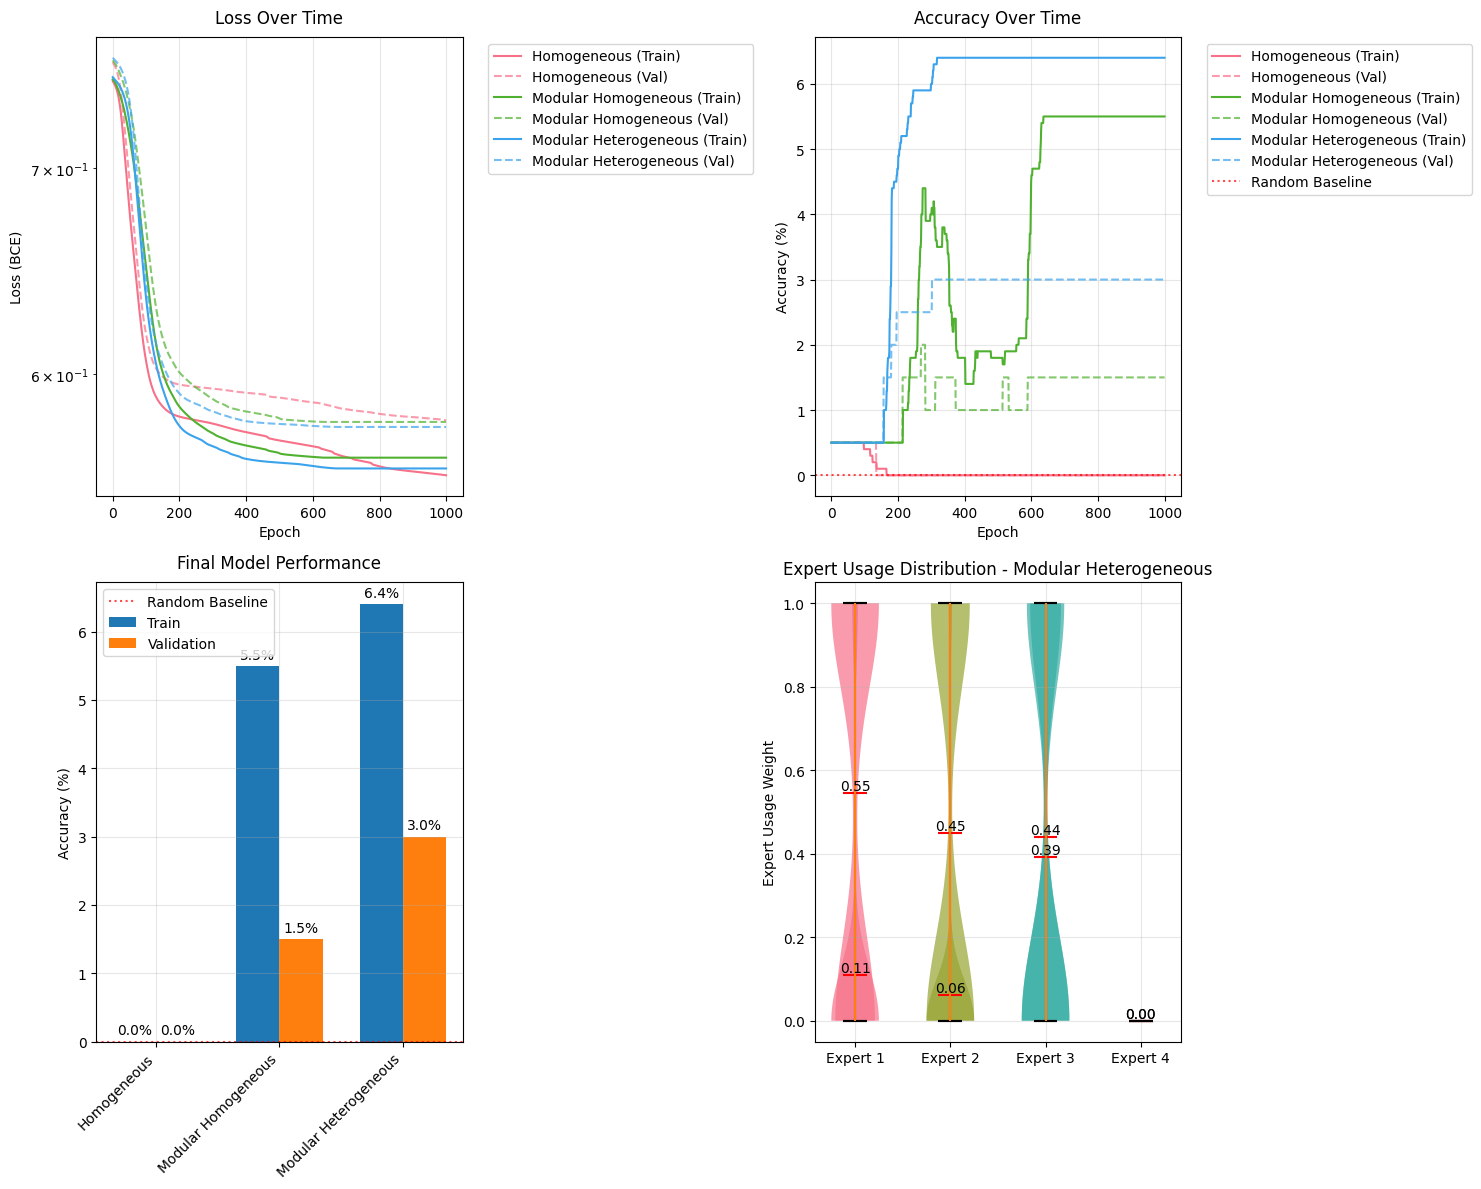

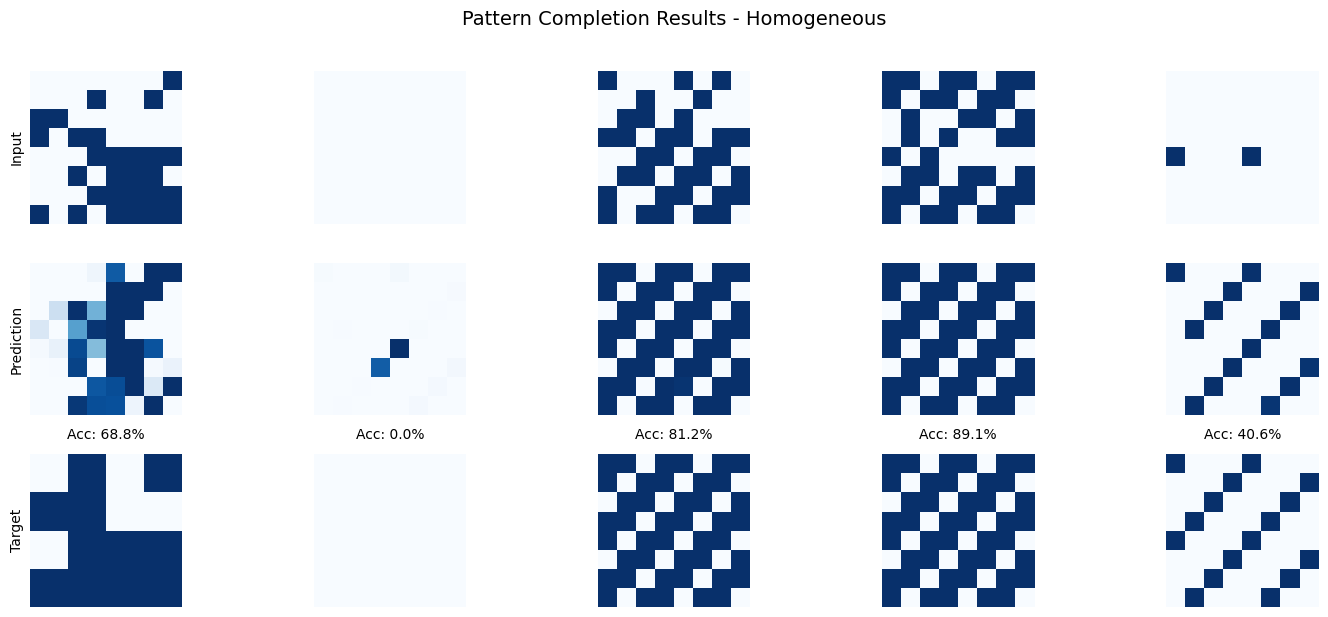

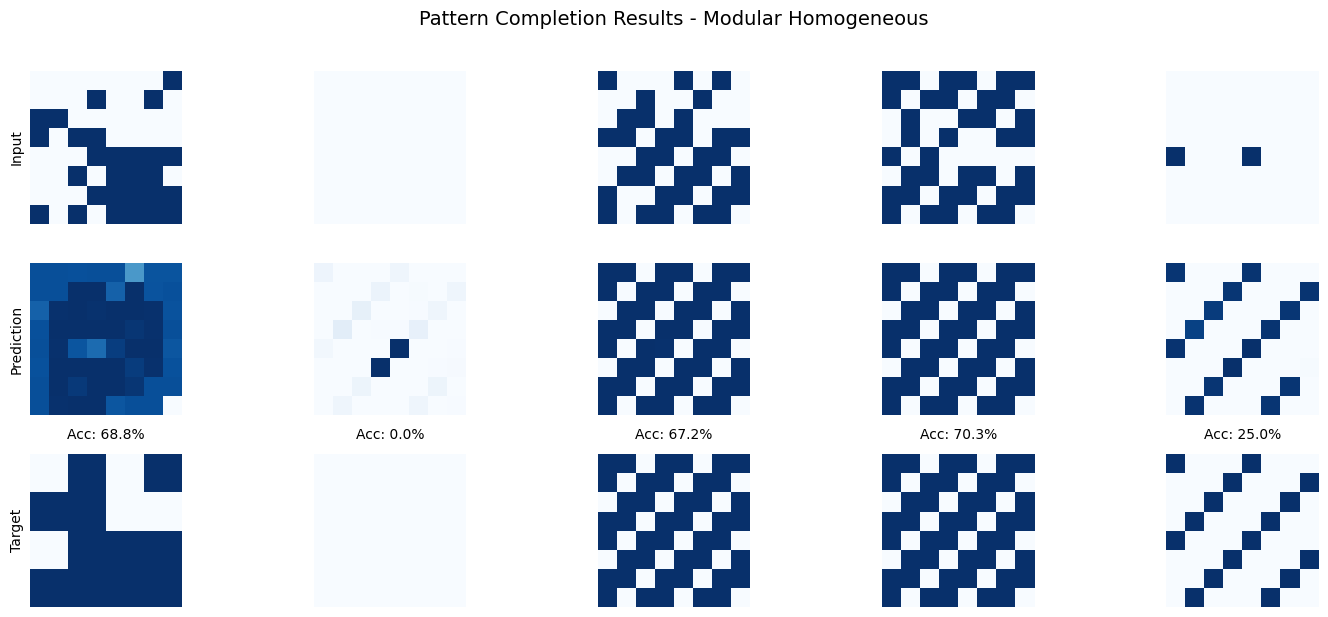

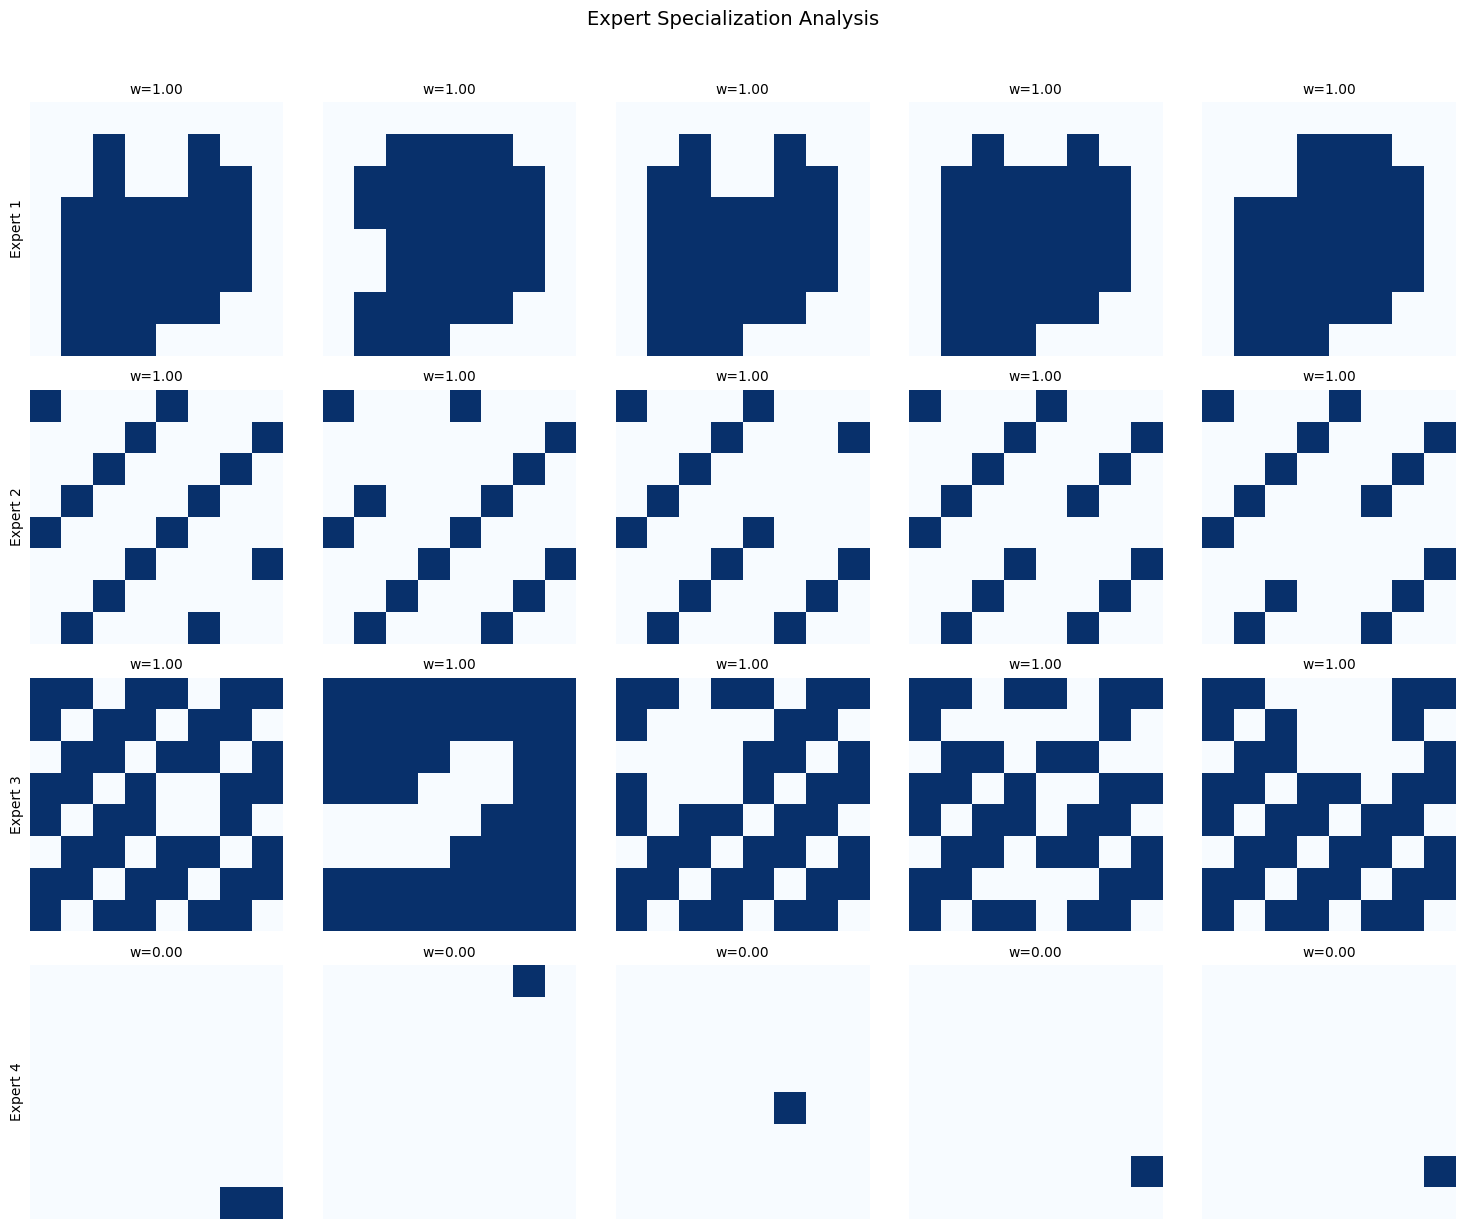

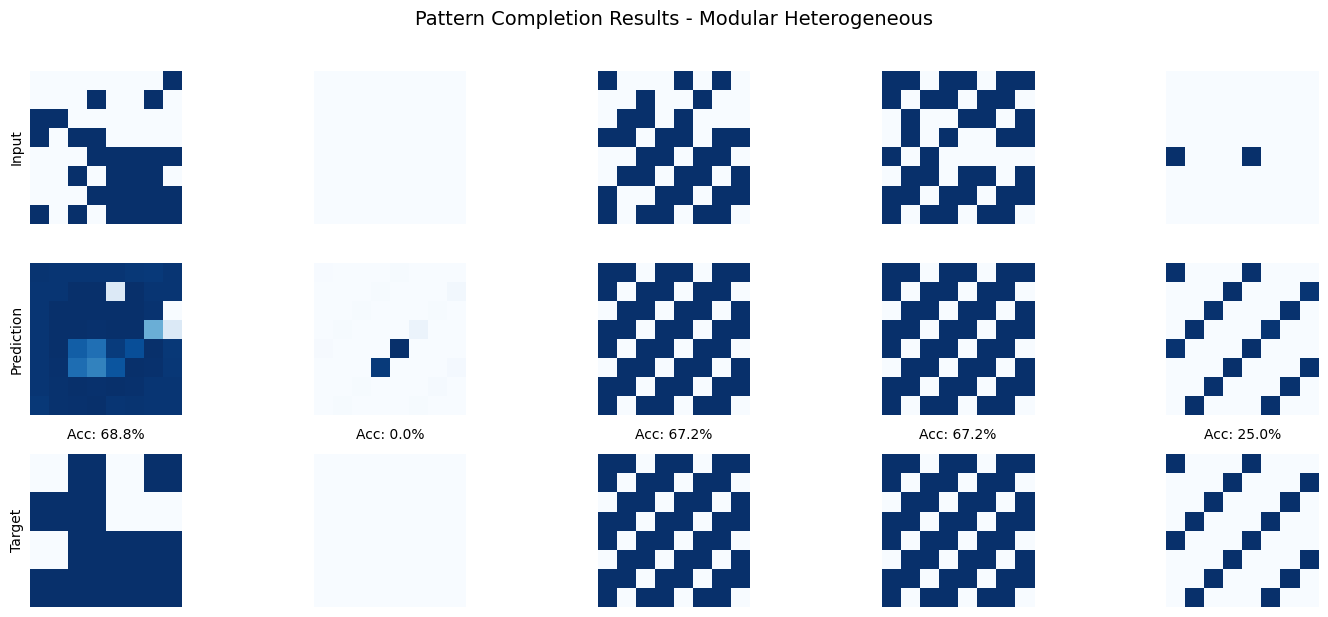

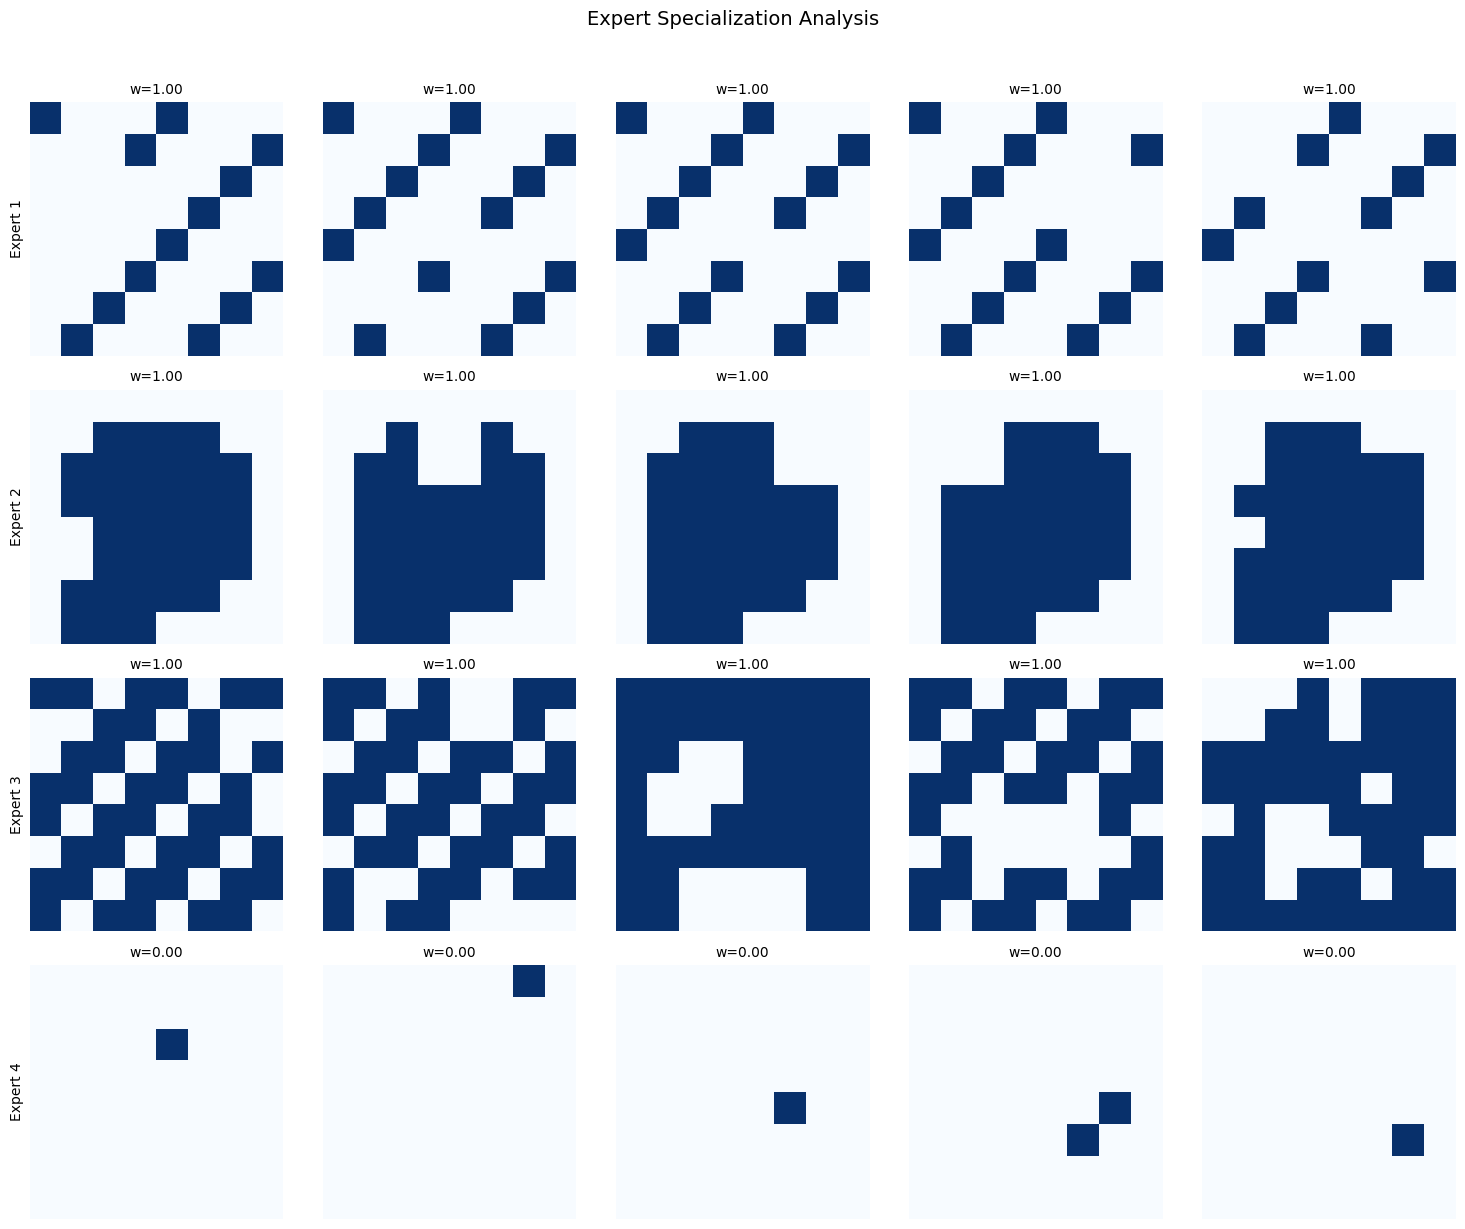


Final Performance Summary:
--------------------------------------------------
Homogeneous:
  Train Accuracy: 0.00%
  Validation Accuracy: 0.00%
  Improvement over random: -0.00%
--------------------------------------------------
Modular Homogeneous:
  Train Accuracy: 5.50%
  Validation Accuracy: 1.50%
  Improvement over random: 1.50%
--------------------------------------------------
Modular Heterogeneous:
  Train Accuracy: 6.40%
  Validation Accuracy: 3.00%
  Improvement over random: 3.00%
--------------------------------------------------

Experiment completed successfully!


In [24]:
def run_pattern_completion_experiment():
    """Run the complete pattern completion experiment"""

    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    # Set parameters
    grid_size = 8
    input_size = grid_size * grid_size  # 64 for 8x8 grid
    total_params = 10000  # Increased parameter count for harder task
    num_experts = 4
    num_epochs = 1000  # Reduced for demonstration

    # Generate data
    print("Generating datasets...")
    train_size = 1000
    val_size = 200
    test_size = 50

    train_data, train_targets = generate_complex_patterns(train_size, grid_size)
    val_data, val_targets = generate_complex_patterns(val_size, grid_size)
    test_data, test_targets = generate_complex_patterns(test_size, grid_size)

    # Calculate and display random baseline
    random_baseline = calculate_random_baseline(train_targets)
    print(f"Random Baseline Accuracy: {random_baseline:.2f}%")

    # Initialize models
    print("\nInitializing models...")
    homogeneous = HomogeneousNetwork(input_size, total_params)
    mod_homogeneous = ModularHomogeneous(input_size, total_params, num_experts)
    expert_ratios = [0.4, 0.3, 0.2, 0.1]  # Different sizes for heterogeneous experts
    mod_heterogeneous = ModularHeterogeneous(input_size, total_params, expert_ratios)

    models = {
        'Homogeneous': homogeneous,
        'Modular Homogeneous': mod_homogeneous,
        'Modular Heterogeneous': mod_heterogeneous
    }

    # Train all models
    print("\nTraining models...")
    histories = {}

    for name, model in models.items():
        print(f"\nTraining {name} model...")
        history = train_and_evaluate(
            model=model,
            train_data=train_data,
            train_targets=train_targets,
            val_data=val_data,
            val_targets=val_targets,
            epochs=num_epochs
        )
        histories[name] = history

    # Create all visualizations
    print("\nGenerating visualizations...")
    plot_all_visualizations(
        models=models,
        histories=histories,
        data=train_data,
        targets=train_targets,
        test_data=test_data,
        test_targets=test_targets,
        epochs=num_epochs,
        grid_size=grid_size
    )

    # Print final performance summary
    print("\nFinal Performance Summary:")
    print("-" * 50)
    for name, history in histories.items():
        final_train_acc = history['train_acc'][-1]
        final_val_acc = history['val_acc'][-1]
        print(f"{name}:")
        print(f"  Train Accuracy: {final_train_acc:.2f}%")
        print(f"  Validation Accuracy: {final_val_acc:.2f}%")
        print(f"  Improvement over random: {final_val_acc - random_baseline:.2f}%")
        print("-" * 50)

    return models, histories

if __name__ == "__main__":
    print("Starting Pattern Completion Experiment...")
    print("=" * 50)

    # Check if CUDA is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    try:
        # Run the experiment
        models, histories = run_pattern_completion_experiment()
        print("\nExperiment completed successfully!")

    except Exception as e:
        print(f"\nAn error occurred during the experiment:")
        print(f"Error: {str(e)}")
        raise